In [1]:
# !pip install geopandas rasterio shapely scipy scikit-learn scikit-image seaborn matplotlib_scalebar

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("Environment location:", os.path.dirname(sys.executable))

Python executable: C:\Users\colto\Documents\GitHub\saocom_project\.venv\Scripts\python.exe
Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Environment location: C:\Users\colto\Documents\GitHub\saocom_project\.venv\Scripts


### Setup

In [3]:
from unittest.mock import sentinel
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, rowcol
from rasterio.mask import mask
from rasterio import features
from shapely.geometry import Point, box, shape
from rasterio.features import shapes
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
from dbfread import DBF

DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
print(DATA_DIR)

COHERENCE_THRESHOLD = 0.3
NODATA = -9999
GRID_SIZE = 10
TARGET_CRS = 'EPSG:32632'

CORINE_CLASSES = {
    111: 'Continuous urban fabric', 112: 'Discontinuous urban fabric',
    121: 'Industrial or commercial units', 122: 'Road and rail networks and associated land',
    123: 'Port areas', 124: 'Airports', 131: 'Mineral extraction sites',
    132: 'Dump sites', 133: 'Construction sites', 141: 'Green urban areas',
    142: 'Sport and leisure facilities', 211: 'Non-irrigated arable land',
    212: 'Permanently irrigated land', 213: 'Rice fields', 221: 'Vineyards',
    222: 'Fruit trees and berry plantations', 223: 'Olive groves',
    231: 'Pastures', 241: 'Annual crops associated with permanent crops',
    242: 'Complex cultivation patterns', 243: 'Agriculture/natural vegetation mix',
    244: 'Agro-forestry areas', 311: 'Broad-leaved forest',
    312: 'Coniferous forest', 313: 'Mixed forest', 321: 'Natural grasslands',
    322: 'Moors and heathland', 323: 'Sclerophyllous vegetation',
    324: 'Transitional woodland-shrub', 331: 'Beaches, dunes, sands',
    332: 'Bare rocks', 333: 'Sparsely vegetated areas', 334: 'Burnt areas',
    335: 'Glaciers and perpetual snow', 411: 'Inland marshes',
    412: 'Peat bogs', 421: 'Salt marshes', 422: 'Salines',
    423: 'Intertidal flats', 511: 'Water courses', 512: 'Water bodies',
    521: 'Coastal lagoons', 522: 'Estuaries', 523: 'Sea and ocean'
}

CORINE_COLORS = {
    111: (102, 0, 102), 112: (153, 51, 153), 121: (204, 102, 204), 122: (80, 80, 80),
    123: (120, 120, 120), 124: (160, 160, 160), 131: (255, 0, 255), 132: (178, 34, 34),
    133: (255, 150, 180), 141: (120, 200, 120), 142: (100, 180, 100),
    211: (230, 230, 50), 212: (235, 200, 0), 213: (220, 180, 0), 221: (255, 140, 0),
    222: (255, 165, 79), 223: (204, 153, 0), 231: (210, 210, 80), 241: (200, 170, 100),
    242: (210, 160, 70), 243: (190, 150, 80), 244: (179, 143, 0),
    311: (0, 153, 102), 312: (0, 102, 76), 313: (0, 128, 128), 321: (150, 220, 150),
    322: (102, 204, 153), 323: (130, 180, 130), 324: (51, 153, 102), 331: (210, 180, 140),
    332: (140, 140, 140), 333: (170, 170, 120), 334: (40, 40, 40), 335: (180, 210, 230),
    411: (120, 170, 230), 412: (80, 140, 220), 421: (150, 190, 240), 422: (140, 170, 210),
    423: (100, 160, 210), 511: (0, 102, 204), 512: (0, 76, 153), 521: (51, 102, 153),
    522: (0, 51, 102), 523: (0, 25, 76)
}
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}

file_discovery = {
    'saocom': ("saocom_csv", "*.csv"),
    'tinitaly': ("tinitaly", "*.tif"),
    'copernicus': ("copernicus", "*.tif"),
    'corine': ("ground_cover", "*.tif"),
    'sentinel': ("sentinel_data", "*.tif")
}
for key, (subdir, pattern) in file_discovery.items():
    files = list((DATA_DIR / subdir).glob(pattern))
    globals()[f'{key}_path'] = files[0] if files else None

corine_dbf_path = None
if corine_path:
    candidates = list((DATA_DIR / "ground_cover").glob(f"{corine_path.name}.vat.dbf"))
    corine_dbf_path = candidates[0] if candidates else None

data


### Load Data

In [4]:
df = pd.read_csv(saocom_path)
df.columns = ['ID', 'SVET', 'LVET', 'LAT', 'LAT2', 'LON', 'LON2', 'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']

for col in ['LAT', 'LON', 'LAT2', 'LON2', 'HEIGHT', 'COHER']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['LAT', 'LON', 'LAT2', 'LON2', 'HEIGHT', 'COHER']).query('LAT2 != 0 and LON2 != 0')
df.rename(columns={'LAT': 'LAT_old', 'LON': 'LON_old', 'LAT2': 'LAT', 'LON2': 'LON'}, inplace=True)
df_filtered = df[df['COHER'] >= COHERENCE_THRESHOLD]

saocom_gdf = gpd.GeoDataFrame(
    df_filtered,
    geometry=[Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])],
    crs='EPSG:4326'
).to_crs(TARGET_CRS)
saocom_gdf['x_utm'] = saocom_gdf.geometry.x
saocom_gdf['y_utm'] = saocom_gdf.geometry.y

def _read_raster_meta(path):
    with rasterio.open(path) as src:
        return src.crs, src.res, src.bounds, src.nodata

tinitaly_crs, tinitaly_res, tinitaly_bounds, tinitaly_nodata = _read_raster_meta(tinitaly_path)
copernicus_crs, copernicus_res, copernicus_bounds, copernicus_nodata = _read_raster_meta(copernicus_path)

### HORIZONTAL DATUM VERIFICATION

In [5]:
from sklearn.neighbors import NearestNeighbors

def remove_isolated_knn(gdf, k=5, distance_threshold=100):
    coords = np.column_stack((gdf.geometry.x, gdf.geometry.y))
    distances = NearestNeighbors(n_neighbors=k+1).fit(coords).kneighbors(coords, return_distance=True)[0]
    return gdf[(distances[:, 1:].mean(1) < distance_threshold)].reset_index(drop=True)

# ---- Horizontal datum verification
tinitaly_needs_reproject  = str(tinitaly_crs)  != TARGET_CRS
copernicus_needs_reproject = str(copernicus_crs) != TARGET_CRS
# corine_needs_reproject   = str(corine_crs)   != TARGET_CRS

# ---- Vertical datum verification
tinitaly_wkt, copernicus_wkt = tinitaly_crs.to_wkt(), copernicus_crs.to_wkt()
tinitaly_vertical   = ('EGM2008' in tinitaly_wkt)   or ('geoid' in tinitaly_wkt.lower())
copernicus_vertical = ('EGM2008' in copernicus_wkt) or ('geoid' in copernicus_wkt.lower())

# ---- Study area bounds / hull
study_bounds = saocom_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
study_area_poly = box(*study_bounds)
study_area_gdf = gpd.GeoDataFrame([1], geometry=[study_area_poly], crs=TARGET_CRS)
saocom_gdf = remove_isolated_knn(saocom_gdf, k=5, distance_threshold=100)
data_hull = saocom_gdf.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[data_hull], crs=TARGET_CRS)

# ---- 10m grid parameters
xmin_grid, ymin_grid, xmax_grid, ymax_grid = (
    np.floor(study_bounds[0]/GRID_SIZE)*GRID_SIZE,
    np.floor(study_bounds[1]/GRID_SIZE)*GRID_SIZE,
    np.ceil( study_bounds[2]/GRID_SIZE)*GRID_SIZE,
    np.ceil( study_bounds[3]/GRID_SIZE)*GRID_SIZE
)
grid_width  = int((xmax_grid - xmin_grid)/GRID_SIZE)
grid_height = int((ymax_grid - ymin_grid)/GRID_SIZE)
target_transform = from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, grid_width, grid_height)

# ---- Reference dataset metadata
reference_dems = {
    'tinitaly_crop': {
        'path': tinitaly_path,
        'crs': tinitaly_crs,
        'needs_reproject': tinitaly_needs_reproject,
        'vertical_datum': 'WGS84 ellipsoid'
    },
    'copernicus': {
        'path': copernicus_path,
        'crs': copernicus_crs,
        'needs_reproject': copernicus_needs_reproject,
        'vertical_datum': 'EGM2008 geoid'
    }
}


### RESAMPLE TO 10M

In [6]:
# --- Resample helpers (10 m)
profile = {
    'driver':'GTiff','dtype':'float32','width':grid_width,'height':grid_height,
    'count':1,'crs':TARGET_CRS,'transform':target_transform,
    'nodata':NODATA,'compress':'lzw'
}

def _resample_to_10m(src_path, out_name):
    arr = np.full((grid_height, grid_width), NODATA, np.float32)
    with rasterio.open(src_path) as src:
        reproject(
            rasterio.band(src, 1), arr,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=target_transform, dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata, dst_nodata=NODATA
        )
    out_path = RESULTS_DIR / out_name
    with rasterio.open(out_path, 'w', **profile) as dst: dst.write(arr, 1)
    return arr, out_path

# --- Resample TINITALY & Copernicus
tinitaly_10m, tinitaly_10m_path       = _resample_to_10m(tinitaly_path,  "tinitaly_10m.tif")
copernicus_10m, copernicus_10m_path   = _resample_to_10m(copernicus_path,"copernicus_10m.tif")

# --- Update reference metadata
reference_dems['tinitaly_crop'].update(resampled_path=tinitaly_10m_path, is_10m=True)
reference_dems['copernicus'].update(resampled_path=copernicus_10m_path, is_10m=True)


### CREATE RASTERIZED MASK FROM SAOCOM CONVEX HULL

In [7]:
# --- Rasterized hull mask (10 m grid)
hull_mask = features.rasterize(
    [data_hull], out_shape=(grid_height, grid_width),
    transform=target_transform, fill=0, all_touched=True, dtype='uint8'
).astype(bool)

def _mask_and_write(arr, out_name):
    masked = arr.copy()
    masked[~hull_mask] = NODATA
    out_path = RESULTS_DIR / out_name
    with rasterio.open(out_path, 'w', **profile) as dst: dst.write(masked, 1)
    return masked, out_path

# --- Mask + save
tinitaly_10m,     tinitaly_masked_path   = _mask_and_write(tinitaly_10m,   "tinitaly_10m_masked.tif")
copernicus_10m,   copernicus_masked_path = _mask_and_write(copernicus_10m, "copernicus_10m_masked.tif")

# --- Update reference metadata
reference_dems['tinitaly_crop']['masked_path'] = tinitaly_masked_path
reference_dems['copernicus']['masked_path']    = copernicus_masked_path


### SAMPLE REFERENCE DEMS AT SAOCOM LOCATIONS

In [8]:
# --- Sample reference DEMs at SAOCOM locations (vectorized)
xs, ys = saocom_gdf.geometry.x.values, saocom_gdf.geometry.y.values
rows, cols = rowcol(target_transform, xs, ys)
inb = (rows>=0)&(rows<grid_height)&(cols>=0)&(cols<grid_width)

def _sample(arr):
    out = np.full(len(saocom_gdf), np.nan, dtype=np.float32)
    v = arr[rows[inb], cols[inb]]
    out[inb] = np.where(v==NODATA, np.nan, v)
    return out

saocom_gdf['tinitaly_height']   = _sample(tinitaly_10m)
saocom_gdf['copernicus_height'] = _sample(copernicus_10m)
saocom_gdf['HEIGHT_RELATIVE']   = saocom_gdf['HEIGHT']

# --- Calibration helper (constant offset)
def _calibrate(ref_col, out_col):
    m = (
        (saocom_gdf['COHER']>=0.8) &
        saocom_gdf[ref_col].notna() &
        saocom_gdf['HEIGHT_RELATIVE'].notna() &
        (np.abs(saocom_gdf['HEIGHT_RELATIVE'])<1000)
    )
    sp = saocom_gdf[m]
    diff = sp[ref_col] - sp['HEIGHT_RELATIVE']
    offset = np.median(diff)
    saocom_gdf[out_col] = saocom_gdf['HEIGHT_RELATIVE'] + offset
    rmse = np.sqrt(np.mean((sp[ref_col] - (sp['HEIGHT_RELATIVE'] + offset))**2))
    return offset, rmse, len(sp)

# --- Calibrate to TINITALY & Copernicus
offset_tinitaly,  rmse_tin, n_tin = _calibrate('tinitaly_height',   'HEIGHT_ABSOLUTE_TIN')
offset_copernicus, rmse_cop, n_cop = _calibrate('copernicus_height', 'HEIGHT_ABSOLUTE_COP')

# --- Concise report
print(f"TINITALY: n={n_tin:,}, offset={offset_tinitaly:.3f} m, RMSE={rmse_tin:.3f} m")
print(f"COPERNICUS: n={n_cop:,}, offset={offset_copernicus:.3f} m, RMSE={rmse_cop:.3f} m")
print("Recommendation: Use HEIGHT_ABSOLUTE_TIN (usually lower RMSE).")


TINITALY: n=46,920, offset=4.308 m, RMSE=4.955 m
COPERNICUS: n=46,939, offset=4.761 m, RMSE=4.160 m
Recommendation: Use HEIGHT_ABSOLUTE_TIN (usually lower RMSE).


### CREATE SAOCOM COVERAGE GRID

In [9]:
# --- SAOCOM coverage grid (10 m)
saocom_rows, saocom_cols = rowcol(
    target_transform,
    saocom_gdf.geometry.x.values,
    saocom_gdf.geometry.y.values
)
inb = (saocom_rows>=0)&(saocom_rows<grid_height)&(saocom_cols>=0)&(saocom_cols<grid_width)
saocom_coverage = np.zeros((grid_height, grid_width), dtype=bool)
saocom_coverage[saocom_rows[inb], saocom_cols[inb]] = True

# --- Void stats (inside hull, excluding nodata)
study_area_mask = hull_mask
void_mask = study_area_mask & ~saocom_coverage

n_total_cells     = study_area_mask.sum()
n_occupied_cells  = (study_area_mask & saocom_coverage).sum()
n_void_cells      = void_mask.sum()
void_percentage   = 100 * n_void_cells / n_total_cells if n_total_cells else 0
print(void_percentage)

# --- Save void mask raster (0=data area, 1=void, 255=outside)
void_mask_path = RESULTS_DIR / "saocom_void_mask.tif"
profile_void = {**profile, 'dtype':'uint8', 'nodata':255}
void_raster = np.where(~study_area_mask, 255, np.where(void_mask, 1, 0)).astype(np.uint8)

with rasterio.open(void_mask_path, 'w', **profile_void) as dst:
    dst.write(void_raster, 1)


87.0403491489293


### LOAD REFERENCE DEM DATA (Already in memory from Cell 4)

In [10]:
# --- Load reference DEM data (already in memory)
tinitaly_data   = tinitaly_10m.copy()
copernicus_data = copernicus_10m.copy()

# --- Elevation difference & valid mask
elevation_diff = tinitaly_data - copernicus_data
valid_mask     = (tinitaly_data != NODATA) & (copernicus_data != NODATA)

valid_pixels    = int(valid_mask.sum())
valid_diffs     = elevation_diff[valid_mask]
valid_tinitaly  = tinitaly_data[valid_mask]
valid_copernicus= copernicus_data[valid_mask]

# --- Reference comparison statistics
m  = float(np.mean(valid_diffs))
md = float(np.median(valid_diffs))
sd = float(np.std(valid_diffs))
rm = float(np.sqrt(np.mean(valid_diffs**2)))
ma = float(np.mean(np.abs(valid_diffs)))
nmad = float(1.4826 * np.median(np.abs(valid_diffs - md)))
ref_metrics = {
    'n_pixels': valid_pixels, 'mean_diff': m, 'median_diff': md, 'std_diff': sd,
    'rmse': rm, 'mae': ma, 'nmad': nmad,
    'min_diff': float(np.min(valid_diffs)), 'max_diff': float(np.max(valid_diffs)),
    'correlation': float(np.corrcoef(valid_tinitaly, valid_copernicus)[0,1])
}

# --- Equality tolerance using NMAD
equal_tolerance = ref_metrics['nmad']

# --- Directional comparison grids with equality buffer
tinitaly_higher_mask = valid_mask & (elevation_diff >  equal_tolerance)
tinitaly_lower_mask  = valid_mask & (elevation_diff < -equal_tolerance)
roughly_equal_mask   = valid_mask & (np.abs(elevation_diff) <= equal_tolerance)

tinitaly_higher_data = np.where(tinitaly_higher_mask, elevation_diff, np.nan)
tinitaly_lower_data  = np.where(tinitaly_lower_mask,  elevation_diff, np.nan)
roughly_equal_data   = np.where(roughly_equal_mask,   elevation_diff, np.nan)

higher_pixels = int(tinitaly_higher_mask.sum())
lower_pixels  = int(tinitaly_lower_mask.sum())
equal_pixels  = int(roughly_equal_mask.sum())

pct_higher = float(100 * higher_pixels / valid_pixels) if valid_pixels else 0.0
pct_lower  = float(100 * lower_pixels  / valid_pixels) if valid_pixels else 0.0
pct_equal  = float(100 * equal_pixels  / valid_pixels) if valid_pixels else 0.0

# --- Height statistics comparison
def calculate_height_stats(data, name):
    v = np.asarray(data)
    v = v[~np.isnan(v)]
    if v.size == 0: return None
    q25, q75 = np.percentile(v, [25, 75])
    return {
        'Dataset': name, 'Count': int(v.size),
        'Min': float(v.min()), 'Max': float(v.max()),
        'Mean': float(v.mean()), 'Median': float(np.median(v)),
        'Std Dev': float(v.std()), 'Range': float(v.max()-v.min()),
        'Q25': float(q25), 'Q75': float(q75), 'IQR': float(q75-q25)
    }

stats_list = [
    calculate_height_stats(saocom_gdf['HEIGHT_RELATIVE'].values, 'SAOCOM (Relative)'),
    calculate_height_stats(saocom_gdf['tinitaly_height'].values,  'TINITALY (at SAOCOM pts)'),
    calculate_height_stats(saocom_gdf['copernicus_height'].values,'Copernicus (at SAOCOM pts)'),
    calculate_height_stats(tinitaly_10m[tinitaly_10m!=NODATA],     'TINITALY (Full Grid)'),
    calculate_height_stats(copernicus_10m[copernicus_10m!=NODATA], 'Copernicus (Full Grid)')
]
stats_df = pd.DataFrame([s for s in stats_list if s])

# --- Compact displays
print("\nHEIGHT STATS SUMMARY (m)\n", stats_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'), sep='')

# SAOCOM vs references
diff_tin_valid = (saocom_gdf['HEIGHT_RELATIVE'] - saocom_gdf['tinitaly_height']).dropna().values
diff_cop_valid = (saocom_gdf['HEIGHT_RELATIVE'] - saocom_gdf['copernicus_height']).dropna().values

def _summ(v):
    return f"mean={np.mean(v):+.3f}, median={np.median(v):+.3f}, sd={np.std(v):.3f}, rmse={np.sqrt(np.mean(v**2)):.3f} m"

print("\nSAOCOM−TINITALY:",  _summ(diff_tin_valid))
print("SAOCOM−Copernicus:", _summ(diff_cop_valid))

# Reference check (TINITALY−Copernicus)
ref_diff_valid = (tinitaly_10m[valid_mask] - copernicus_10m[valid_mask])
ref_diff_valid = ref_diff_valid[~np.isnan(ref_diff_valid)]
print("\nTINITALY−Copernicus:", _summ(ref_diff_valid))



HEIGHT STATS SUMMARY (m)
                   Dataset  Count     Min     Max   Mean  Median  Std Dev   Range    Q25    Q75    IQR
         SAOCOM (Relative)  66765 -562.00 1163.70 340.09  327.00   116.87 1725.70 252.00 418.80 166.80
  TINITALY (at SAOCOM pts)  66690   99.32  825.80 343.79  330.04   116.54  726.48 255.95 421.12 165.17
Copernicus (at SAOCOM pts)  66765  100.09  826.59 345.34  331.56   116.86  726.50 256.84 423.97 167.13
      TINITALY (Full Grid) 493124   98.84  826.76 354.23  341.34   129.15  727.92 256.91 442.43 185.52
    Copernicus (Full Grid) 495376   99.60  827.02 356.89  343.88   129.64  727.42 258.68 446.53 187.85

SAOCOM−TINITALY: mean=-3.911, median=-4.383, sd=14.745, rmse=15.254 m
SAOCOM−Copernicus: mean=-5.251, median=-4.939, sd=14.473, rmse=15.397 m

TINITALY−Copernicus: mean=-2.029, median=-0.585, sd=4.222, rmse=4.684 m


### LOAD DBF LOOKUP TABLE

In [11]:
# --- 3) Load DBF lookup
dbf_table  = DBF(corine_dbf_path, load=True)
lookup_df  = pd.DataFrame(iter(dbf_table))
value_to_code = dict(zip(lookup_df['Value'],   lookup_df['CODE_18']))
value_to_label= dict(zip(lookup_df['Value'],   lookup_df['LABEL3']))
code_to_label = dict(zip(lookup_df['CODE_18'], lookup_df['LABEL3']))

# --- 4) Load, crop by hull, and remap CORINE
with rasterio.open(corine_path) as src:
    hull_corine_crs = hull_gdf.to_crs(src.crs)
    corine_raw, crop_transform = mask(src, hull_corine_crs.geometry, crop=True, filled=False)
    corine_raw     = corine_raw[0]
    corine_crs     = src.crs
    corine_res     = src.res
    corine_nodata  = src.nodata if src.nodata is not None else 255
    corine_bounds  = src.bounds

# Remap: Value → CODE_18 (default 0); keep 0 for nodata
corine_remapped = np.vectorize(value_to_code.get, otypes=[np.uint16])(corine_raw)
corine_remapped[corine_raw == corine_nodata] = 0

# (Optional) Save intermediate remapped crop
corine_remapped_path = RESULTS_DIR / "corine_remapped_cropped.tif"
profile_remapped = {
    'driver':'GTiff','dtype':'uint16','width':corine_remapped.shape[1],'height':corine_remapped.shape[0],
    'count':1,'crs':corine_crs,'transform':crop_transform,'nodata':0,'compress':'lzw'
}
with rasterio.open(corine_remapped_path,'w',**profile_remapped) as dst: dst.write(corine_remapped,1)

# --- 5) Resample to 10 m grid (nearest for categorical)
corine_10m = np.zeros((grid_height, grid_width), dtype=np.uint16)
reproject(
    source=corine_remapped, destination=corine_10m,
    src_transform=crop_transform, src_crs=corine_crs,
    dst_transform=target_transform, dst_crs=TARGET_CRS,
    resampling=Resampling.nearest, src_nodata=0, dst_nodata=0
)

corine_10m_path = RESULTS_DIR / "corine_10m.tif"
profile_10m = {'driver':'GTiff','dtype':'uint16','width':grid_width,'height':grid_height,
               'count':1,'crs':TARGET_CRS,'transform':target_transform,'nodata':0,'compress':'lzw'}
with rasterio.open(corine_10m_path,'w',**profile_10m) as dst: dst.write(corine_10m,1)

# --- 6) Mask to hull
corine_10m_masked = corine_10m.copy()
corine_10m_masked[~hull_mask] = 0
corine_masked_path = RESULTS_DIR / "corine_10m_masked.tif"
with rasterio.open(corine_masked_path,'w',**profile_10m) as dst: dst.write(corine_10m_masked,1)
corine_10m = corine_10m_masked  # update working array

# --- Summary (concise)
unique_codes = np.unique(corine_10m[corine_10m>0])
print(f"CORINE done | CRS={corine_crs} | classes={len(unique_codes)} | res={GRID_SIZE} m")
print(f"Classes: {sorted(unique_codes)}")
print(f"Output: {corine_masked_path}")


CORINE done | CRS=IGNF:ETRS89LAEA | classes=10 | res=10 m
Classes: [np.uint16(112), np.uint16(221), np.uint16(223), np.uint16(231), np.uint16(242), np.uint16(243), np.uint16(311), np.uint16(312), np.uint16(313), np.uint16(331)]
Output: results\corine_10m_masked.tif


### SIMPLE SPATIAL OVERLAP VISUALIZATION

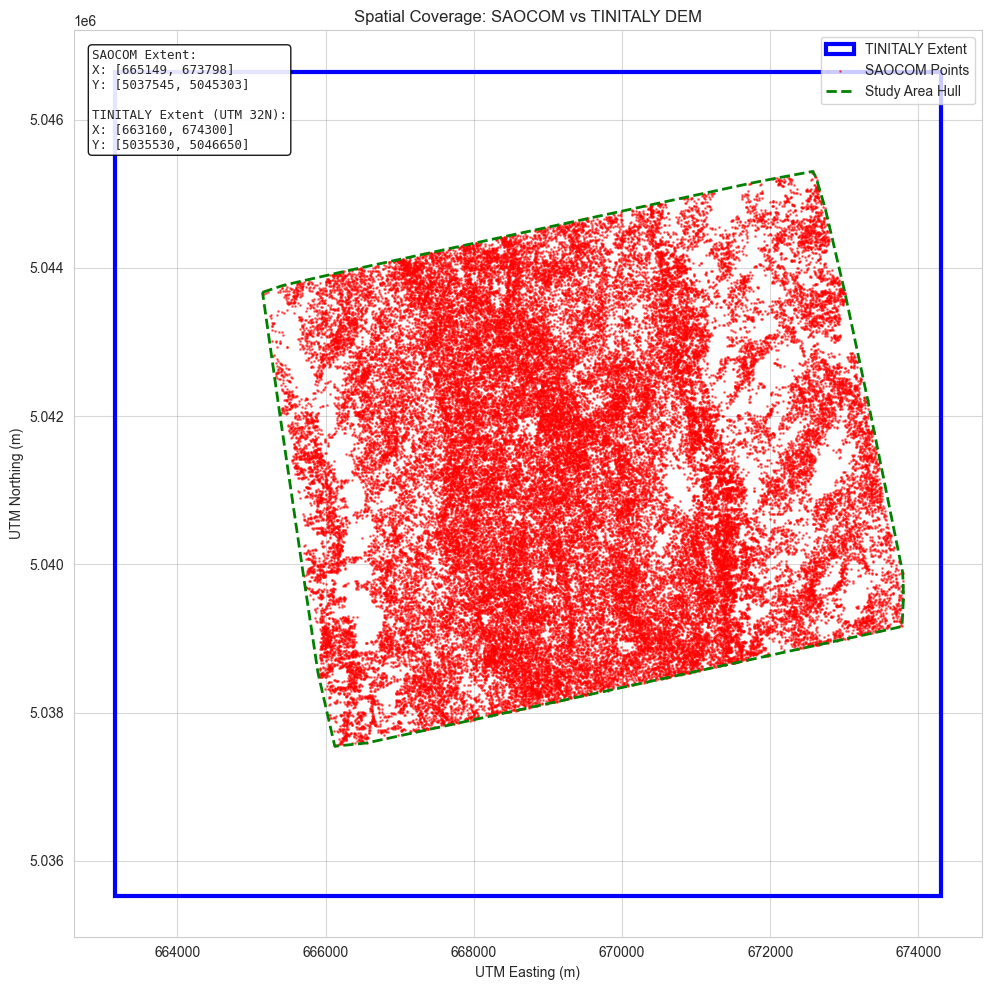


=== OVERLAP CHECK ===
X-axis overlap: True
Y-axis overlap: True
Full overlap: True


In [12]:
# --- Simple spatial overlap visualization
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
ax.set_facecolor('white')

# 1) TINITALY extent (reprojected for plotting)
with rasterio.open(tinitaly_path) as src:
    dem_bounds_target = rasterio.warp.transform_bounds(src.crs, TARGET_CRS, *src.bounds)
    ax.add_patch(Rectangle(
        (dem_bounds_target[0], dem_bounds_target[1]),
        dem_bounds_target[2]-dem_bounds_target[0],
        dem_bounds_target[3]-dem_bounds_target[1],
        linewidth=3, edgecolor='blue', facecolor='none', label='TINITALY Extent'
    ))

# 2) SAOCOM points + 3) hull
saocom_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5, label='SAOCOM Points')
hull_gdf.boundary.plot(ax=ax, color='green', linewidth=2, linestyle='--', label='Study Area Hull')

# Labels / legend / grid
ax.set(xlabel='UTM Easting (m)', ylabel='UTM Northing (m)', title='Spatial Coverage: SAOCOM vs TINITALY DEM')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, color='gray')

# Extent textbox
sxmin, sxmax = saocom_gdf.geometry.x.min(), saocom_gdf.geometry.x.max()
symin, symax = saocom_gdf.geometry.y.min(), saocom_gdf.geometry.y.max()
info_text = (
    f"SAOCOM Extent:\nX: [{sxmin:.0f}, {sxmax:.0f}]\nY: [{symin:.0f}, {symax:.0f}]\n\n"
    f"TINITALY Extent (UTM 32N):\nX: [{dem_bounds_target[0]:.0f}, {dem_bounds_target[2]:.0f}]\n"
    f"Y: [{dem_bounds_target[1]:.0f}, {dem_bounds_target[3]:.0f}]"
)
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9, va='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig(RESULTS_DIR / "spatial_coverage.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Overlap check
print("\n=== OVERLAP CHECK ===")
overlap_x = not (sxmax < dem_bounds_target[0] or sxmin > dem_bounds_target[2])
overlap_y = not (symax < dem_bounds_target[1] or symin > dem_bounds_target[3])
print(f"X-axis overlap: {overlap_x}")
print(f"Y-axis overlap: {overlap_y}")
print(f"Full overlap: {overlap_x and overlap_y}")
if not (overlap_x and overlap_y):
    print("\n⚠️ NO OVERLAP DETECTED - SAOCOM data is outside TINITALY coverage!\n"
          "Use a different TINITALY tile that covers this area.")


### COMPREHENSIVE REFERENCE DEM COMPARISON VISUALIZATION

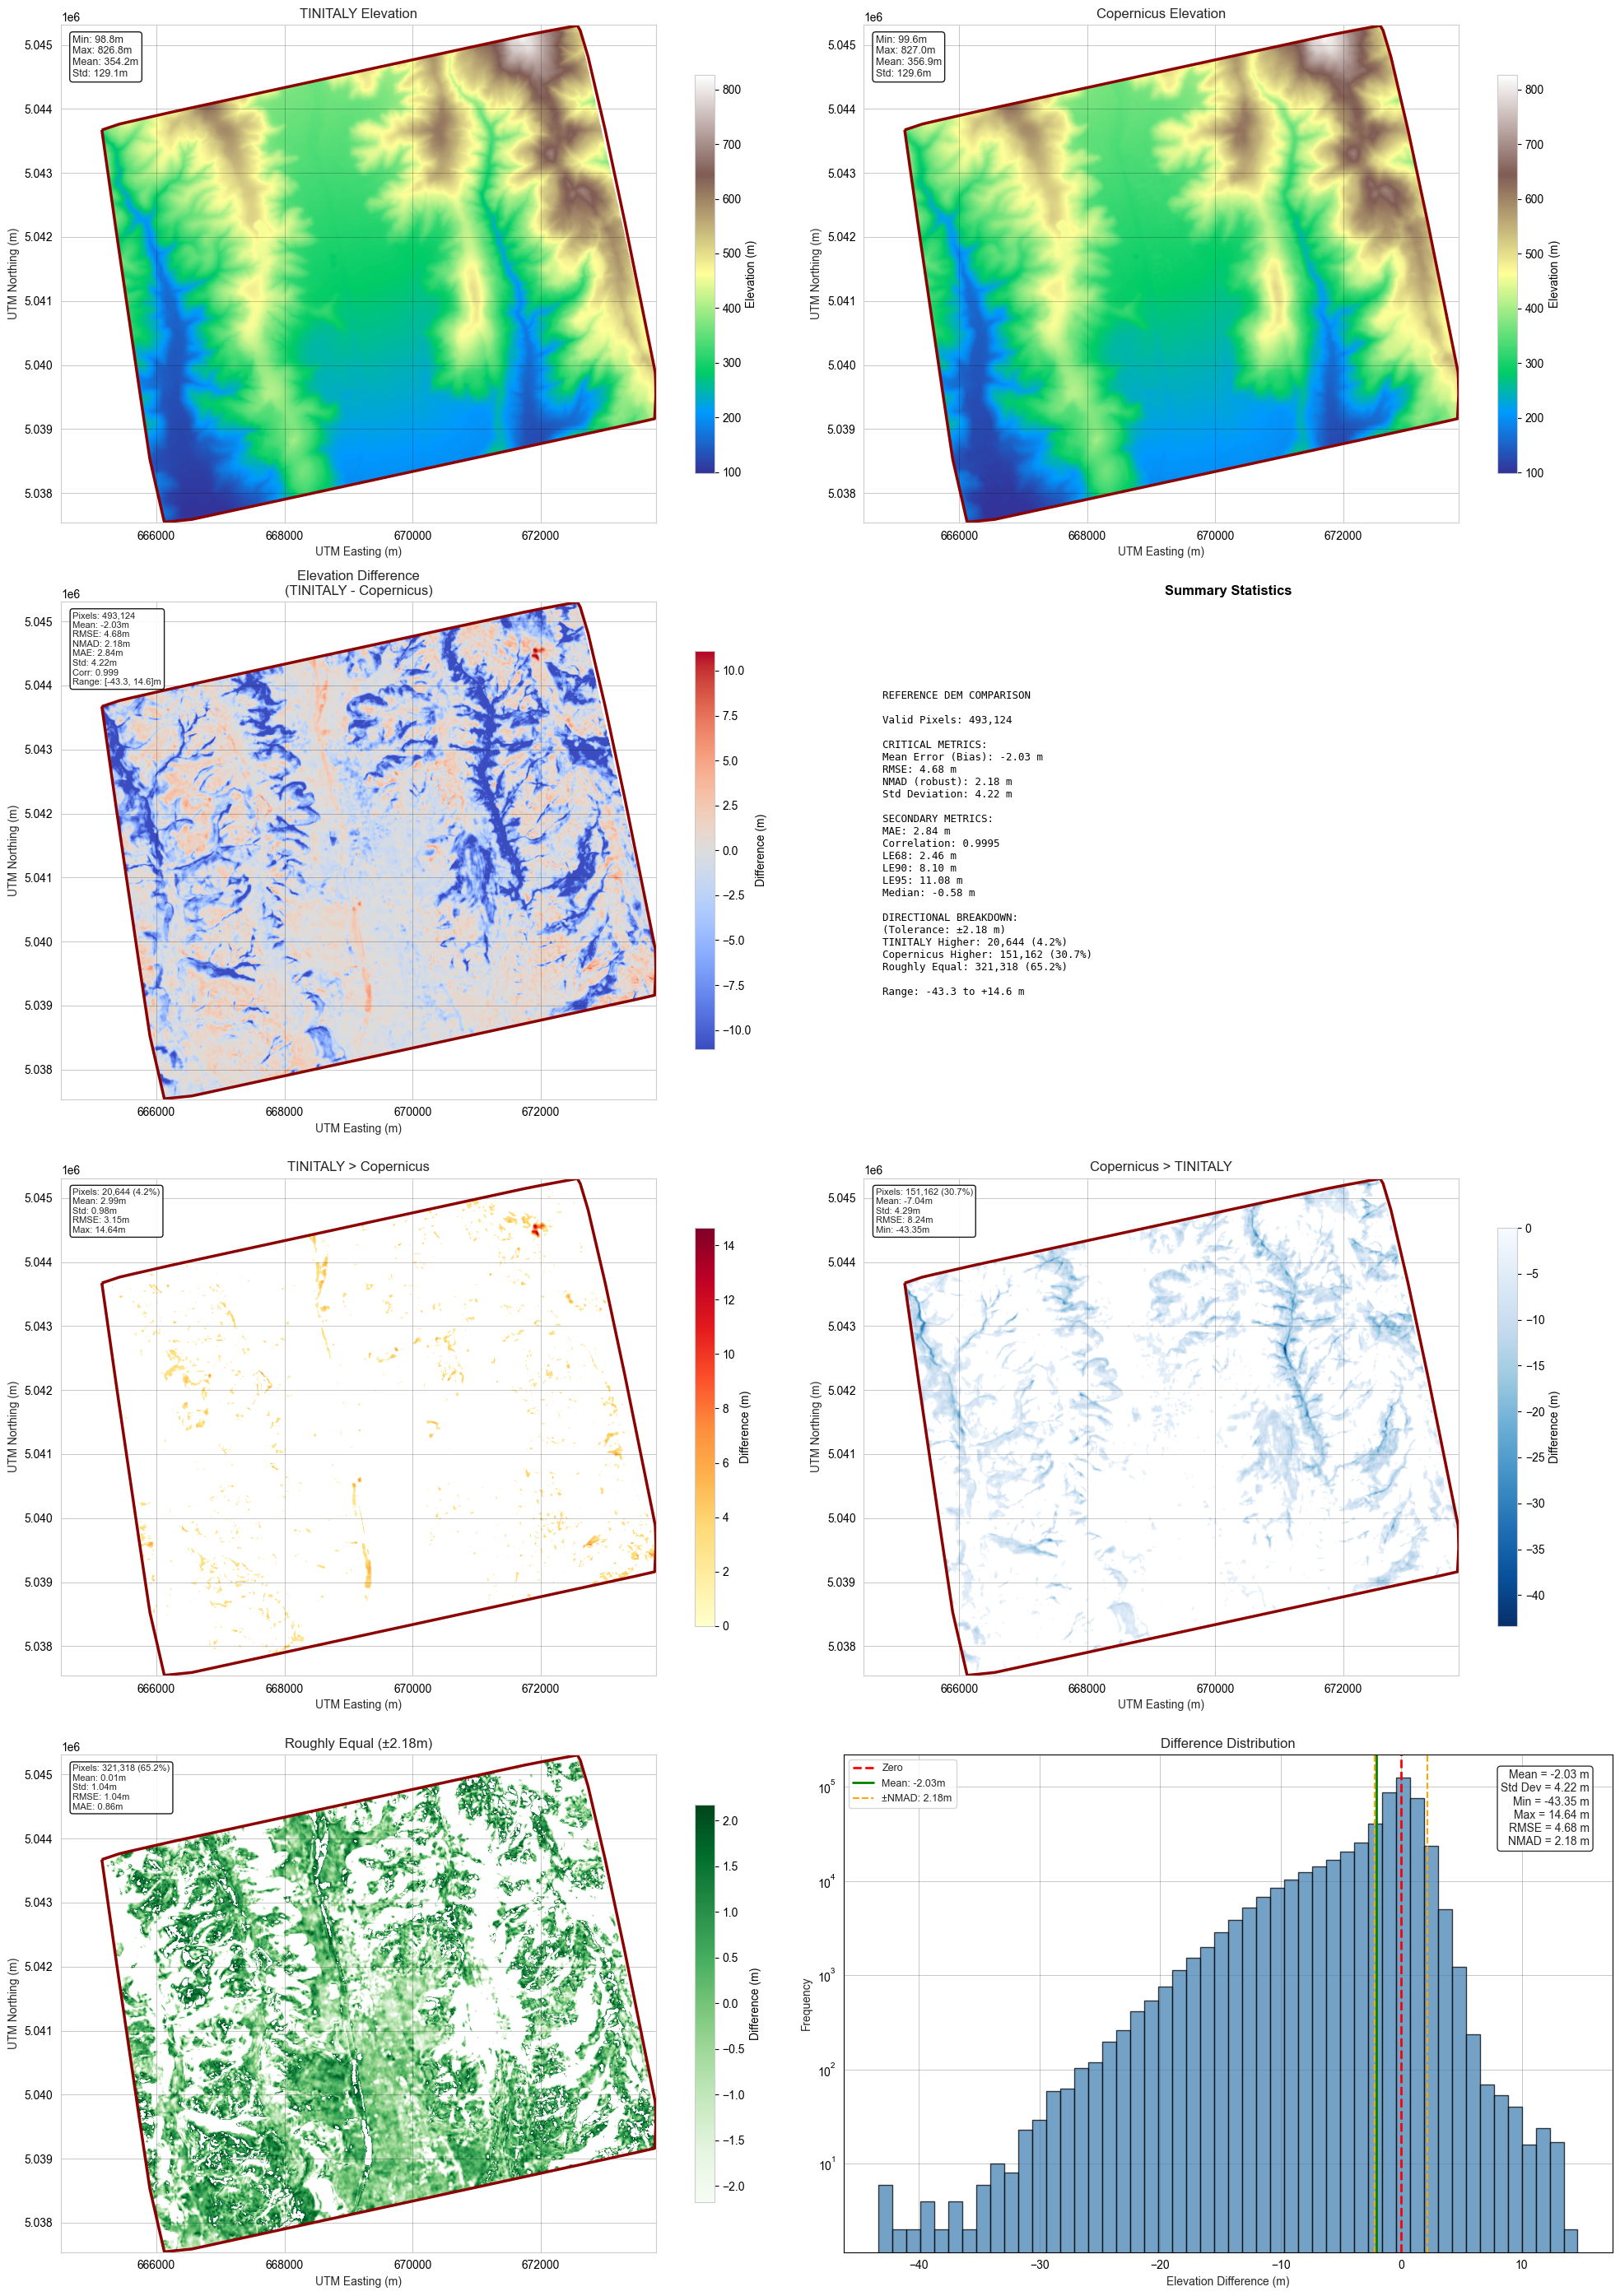

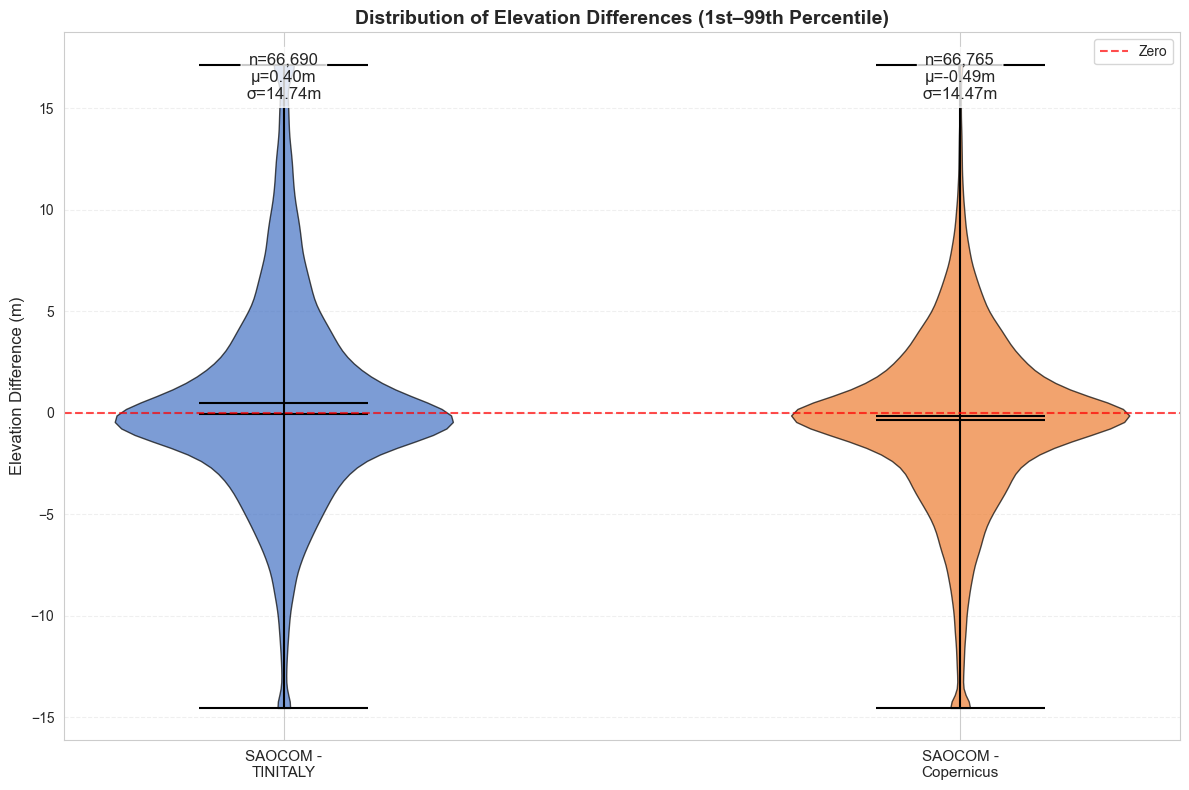


VIOLIN PLOT SUMMARY STATISTICS
         Comparison N Points    Mean  Median Std Dev    RMSE             Range
  SAOCOM - TINITALY   66,690 +0.40 m -0.08 m 14.74 m 14.75 m [-837.1, 643.6] m
SAOCOM - Copernicus   66,765 -0.49 m -0.18 m 14.47 m 14.48 m [-837.5, 639.7] m


In [13]:
# --- Comprehensive reference DEM comparison visualization (condensed)

fig, axes = plt.subplots(4, 2, figsize=(20, 28), facecolor='white')
extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

def _imshow(ax, data, cmap, title, cbar_label, vlims=None, stats_arr=None):
    ax.set_facecolor('white')
    disp = np.ma.masked_equal(data, NODATA) if (data is tinitaly_data or data is copernicus_data) else np.ma.masked_invalid(data)
    cm = cmap.copy(); cm.set_bad(color='white', alpha=0)
    im = ax.imshow(disp, cmap=cm, origin='upper', extent=extent, **({'vmin':vlims[0],'vmax':vlims[1]} if vlims else {}))
    hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
    ax.set(title=title, xlabel='UTM Easting (m)', ylabel='UTM Northing (m)')
    ax.grid(True, color='black', alpha=0.3, linewidth=0.5); ax.tick_params(colors='black')
    cb = plt.colorbar(im, ax=ax, label=cbar_label, shrink=0.8)
    cb.ax.yaxis.label.set_color('black'); cb.ax.tick_params(colors='black')
    if stats_arr is not None and stats_arr.size:
        txt = f"Min: {np.nanmin(stats_arr):.1f}m\nMax: {np.nanmax(stats_arr):.1f}m\nMean: {np.nanmean(stats_arr):.1f}m\nStd: {np.nanstd(stats_arr):.1f}m"
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))
    return im

# 1) TINITALY elevation
_imshow(axes[0,0], tinitaly_data, plt.cm.terrain, 'TINITALY Elevation', 'Elevation (m)', stats_arr=np.where(tinitaly_data!=NODATA, tinitaly_data, np.nan))

# 2) Copernicus elevation
_imshow(axes[0,1], copernicus_data, plt.cm.terrain, 'Copernicus Elevation', 'Elevation (m)', stats_arr=np.where(copernicus_data!=NODATA, copernicus_data, np.nan))

# 3) Difference map (TINITALY − Copernicus) over valid area
diff_display = np.where(valid_mask, elevation_diff, np.nan)
diff_limit   = np.percentile(np.abs(valid_diffs), 95)
stats3 = (
    f"Pixels: {valid_pixels:,}\n"
    f"Mean: {ref_metrics['mean_diff']:+.2f}m\nRMSE: {ref_metrics['rmse']:.2f}m\n"
    f"NMAD: {ref_metrics['nmad']:.2f}m\nMAE: {ref_metrics['mae']:.2f}m\n"
    f"Std: {ref_metrics['std_diff']:.2f}m\nCorr: {ref_metrics['correlation']:.3f}\n"
    f"Range: [{ref_metrics['min_diff']:.1f}, {ref_metrics['max_diff']:.1f}]m"
)
ax = axes[1,0]
_imshow(ax, diff_display, plt.cm.coolwarm, 'Elevation Difference\n(TINITALY - Copernicus)', 'Difference (m)',
        vlims=(-diff_limit, diff_limit))
ax.text(0.02, 0.98, stats3, transform=ax.transAxes, fontsize=8, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# 4) Statistics summary
ax = axes[1,1]; ax.set_facecolor('white'); ax.axis('off'); ax.set_title('Summary Statistics', fontweight='bold', fontsize=12, color='black')
le68, le90, le95 = np.percentile(np.abs(valid_diffs), [68.27, 90, 95])
stats_text = f"""REFERENCE DEM COMPARISON

Valid Pixels: {valid_pixels:,}

CRITICAL METRICS:
Mean Error (Bias): {ref_metrics['mean_diff']:+.2f} m
RMSE: {ref_metrics['rmse']:.2f} m
NMAD (robust): {ref_metrics['nmad']:.2f} m
Std Deviation: {ref_metrics['std_diff']:.2f} m

SECONDARY METRICS:
MAE: {ref_metrics['mae']:.2f} m
Correlation: {ref_metrics['correlation']:.4f}
LE68: {le68:.2f} m
LE90: {le90:.2f} m
LE95: {le95:.2f} m
Median: {ref_metrics['median_diff']:+.2f} m

DIRECTIONAL BREAKDOWN:
(Tolerance: ±{equal_tolerance:.2f} m)
TINITALY Higher: {higher_pixels:,} ({pct_higher:.1f}%)
Copernicus Higher: {lower_pixels:,} ({pct_lower:.1f}%)
Roughly Equal: {equal_pixels:,} ({pct_equal:.1f}%)

Range: {ref_metrics['min_diff']:+.1f} to {ref_metrics['max_diff']:+.1f} m
"""
ax.text(0.05, 0.5, stats_text, transform=ax.transAxes, fontfamily='monospace', fontsize=9, va='center', color='black')

# 5) Where TINITALY > Copernicus
ax = axes[2,0]
_imshow(ax, tinitaly_higher_data, plt.cm.YlOrRd, 'TINITALY > Copernicus', 'Difference (m)', vlims=(0, np.nanmax(tinitaly_higher_data)))
hv = tinitaly_higher_data[~np.isnan(tinitaly_higher_data)]
ax.text(0.02, 0.98, f"Pixels: {higher_pixels:,} ({pct_higher:.1f}%)\nMean: {np.mean(hv):.2f}m\nStd: {np.std(hv):.2f}m\nRMSE: {np.sqrt((hv**2).mean()):.2f}m\nMax: {np.max(hv):.2f}m",
        transform=ax.transAxes, fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# 6) Where TINITALY < Copernicus
ax = axes[2,1]
_imshow(ax, tinitaly_lower_data, plt.cm.Blues_r, 'Copernicus > TINITALY', 'Difference (m)',
        vlims=(np.nanmin(tinitaly_lower_data), 0))
lv = tinitaly_lower_data[~np.isnan(tinitaly_lower_data)]
ax.text(0.02, 0.98, f"Pixels: {lower_pixels:,} ({pct_lower:.1f}%)\nMean: {np.mean(lv):.2f}m\nStd: {np.std(lv):.2f}m\nRMSE: {np.sqrt((lv**2).mean()):.2f}m\nMin: {np.min(lv):.2f}m",
        transform=ax.transAxes, fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# 7) Where roughly equal
ax = axes[3,0]
_imshow(ax, roughly_equal_data, plt.cm.Greens, f'Roughly Equal (±{equal_tolerance:.2f}m)', 'Difference (m)',
        vlims=(-equal_tolerance, equal_tolerance))
ev = roughly_equal_data[~np.isnan(roughly_equal_data)]
ax.text(0.02, 0.98, f"Pixels: {equal_pixels:,} ({pct_equal:.1f}%)\nMean: {np.mean(ev):.2f}m\nStd: {np.std(ev):.2f}m\nRMSE: {np.sqrt((ev**2).mean()):.2f}m\nMAE: {np.mean(np.abs(ev)):.2f}m",
        transform=ax.transAxes, fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# 8) Histogram of differences
ax = axes[3,1]; ax.set_facecolor('white')
n, bins, patches = ax.hist(valid_diffs, bins=50, alpha=0.75, color='steelblue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2, label=f"Mean: {ref_metrics['mean_diff']:+.2f}m")
ax.axvline(equal_tolerance, color='orange', linestyle='--', linewidth=1.5, label=f'±NMAD: {equal_tolerance:.2f}m')
ax.axvline(-equal_tolerance, color='orange', linestyle='--', linewidth=1.5)
ax.text(0.97, 0.97,
        f"Mean = {valid_diffs.mean():+.2f} m\nStd Dev = {valid_diffs.std():.2f} m\nMin = {valid_diffs.min():.2f} m\nMax = {valid_diffs.max():.2f} m\nRMSE = {ref_metrics['rmse']:.2f} m\nNMAD = {ref_metrics['nmad']:.2f} m",
        transform=ax.transAxes, fontsize=10, va='top', ha='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
x_min, x_max = float(valid_diffs.min()), float(valid_diffs.max())
x_pad = (x_max - x_min) * 0.05
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set(xlabel='Elevation Difference (m)', ylabel='Frequency', title='Difference Distribution'); ax.tick_params(colors='black')
ax.set_yscale('log'); ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
for s in ax.spines.values(): s.set_edgecolor('black')

plt.tight_layout()
plt.show()

# =============================================================================
# 1) Prepare difference data
# =============================================================================
saocom_gdf['diff_tinitaly']   = saocom_gdf['HEIGHT_ABSOLUTE_TIN'] - saocom_gdf['tinitaly_height']
saocom_gdf['diff_copernicus'] = saocom_gdf['HEIGHT_ABSOLUTE_COP'] - saocom_gdf['copernicus_height']

if 'coherence_bin' not in saocom_gdf.columns:
    cbins = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    clabels = [f"{cbins[i]:.1f}-{cbins[i+1]:.1f}" for i in range(len(cbins)-1)]
    saocom_gdf['coherence_bin'] = pd.cut(saocom_gdf['COHER'], bins=cbins, labels=clabels, include_lowest=True)

# =============================================================================
# 2) Basic violin plots (filtered to 1st–99th percentile for display)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
plot_data = pd.DataFrame({'SAOCOM - TINITALY': saocom_gdf['diff_tinitaly'], 'SAOCOM - Copernicus': saocom_gdf['diff_copernicus']})
p01, p99 = plot_data.quantile(0.01).min(), plot_data.quantile(0.99).max()
filtered = [plot_data[c].dropna().clip(p01, p99) for c in plot_data.columns]

parts = ax.violinplot(filtered, positions=[1,2], showmeans=True, showmedians=True, showextrema=True)
for pc, col in zip(parts['bodies'], ['#4472C4', '#ED7D31']): pc.set_facecolor(col); pc.set_alpha(0.7); pc.set_edgecolor('black')
for k in ('cbars','cmins','cmaxes','cmedians','cmeans'):
    if k in parts: parts[k].set_edgecolor('black'); parts[k].set_linewidth(1.5)

ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero')
ax.set_xticks([1,2]); ax.set_xticklabels(['SAOCOM -\nTINITALY', 'SAOCOM -\nCopernicus'], fontsize=11)
ax.set_ylabel('Elevation Difference (m)', fontsize=12)
ax.set_title('Distribution of Elevation Differences (1st–99th Percentile)', fontweight='bold', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.legend()

for i, col in enumerate(plot_data.columns, 1):
    data = plot_data[col].dropna()
    ymax = filtered[i-1].max()
    ax.text(i, ymax*0.9, f"n={len(data):,}\nμ={data.mean():.2f}m\nσ={data.std():.2f}m", ha='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout(); plt.show()

# =============================================================================
# 4) Summary statistics table
# =============================================================================
summary_df = pd.DataFrame([{
    'Comparison': 'SAOCOM - TINITALY' if name=='diff_tinitaly' else 'SAOCOM - Copernicus',
    'N Points': f"{len(saocom_gdf[name].dropna()):,}",
    'Mean': f"{saocom_gdf[name].mean():+.2f} m",
    'Median': f"{saocom_gdf[name].median():+.2f} m",
    'Std Dev': f"{saocom_gdf[name].std():.2f} m",
    'RMSE': f"{np.sqrt((saocom_gdf[name].dropna()**2).mean()):.2f} m",
    'Range': f"[{saocom_gdf[name].min():.1f}, {saocom_gdf[name].max():.1f}] m"
} for name in ('diff_tinitaly','diff_copernicus')])

print("\n" + "="*80 + "\nVIOLIN PLOT SUMMARY STATISTICS\n" + "="*80)
print(summary_df.to_string(index=False))
print("="*80)


### SAOCOM HEIGHT RESIDUAL OUTLIER DETECTION AND VISUALIZATION

66765


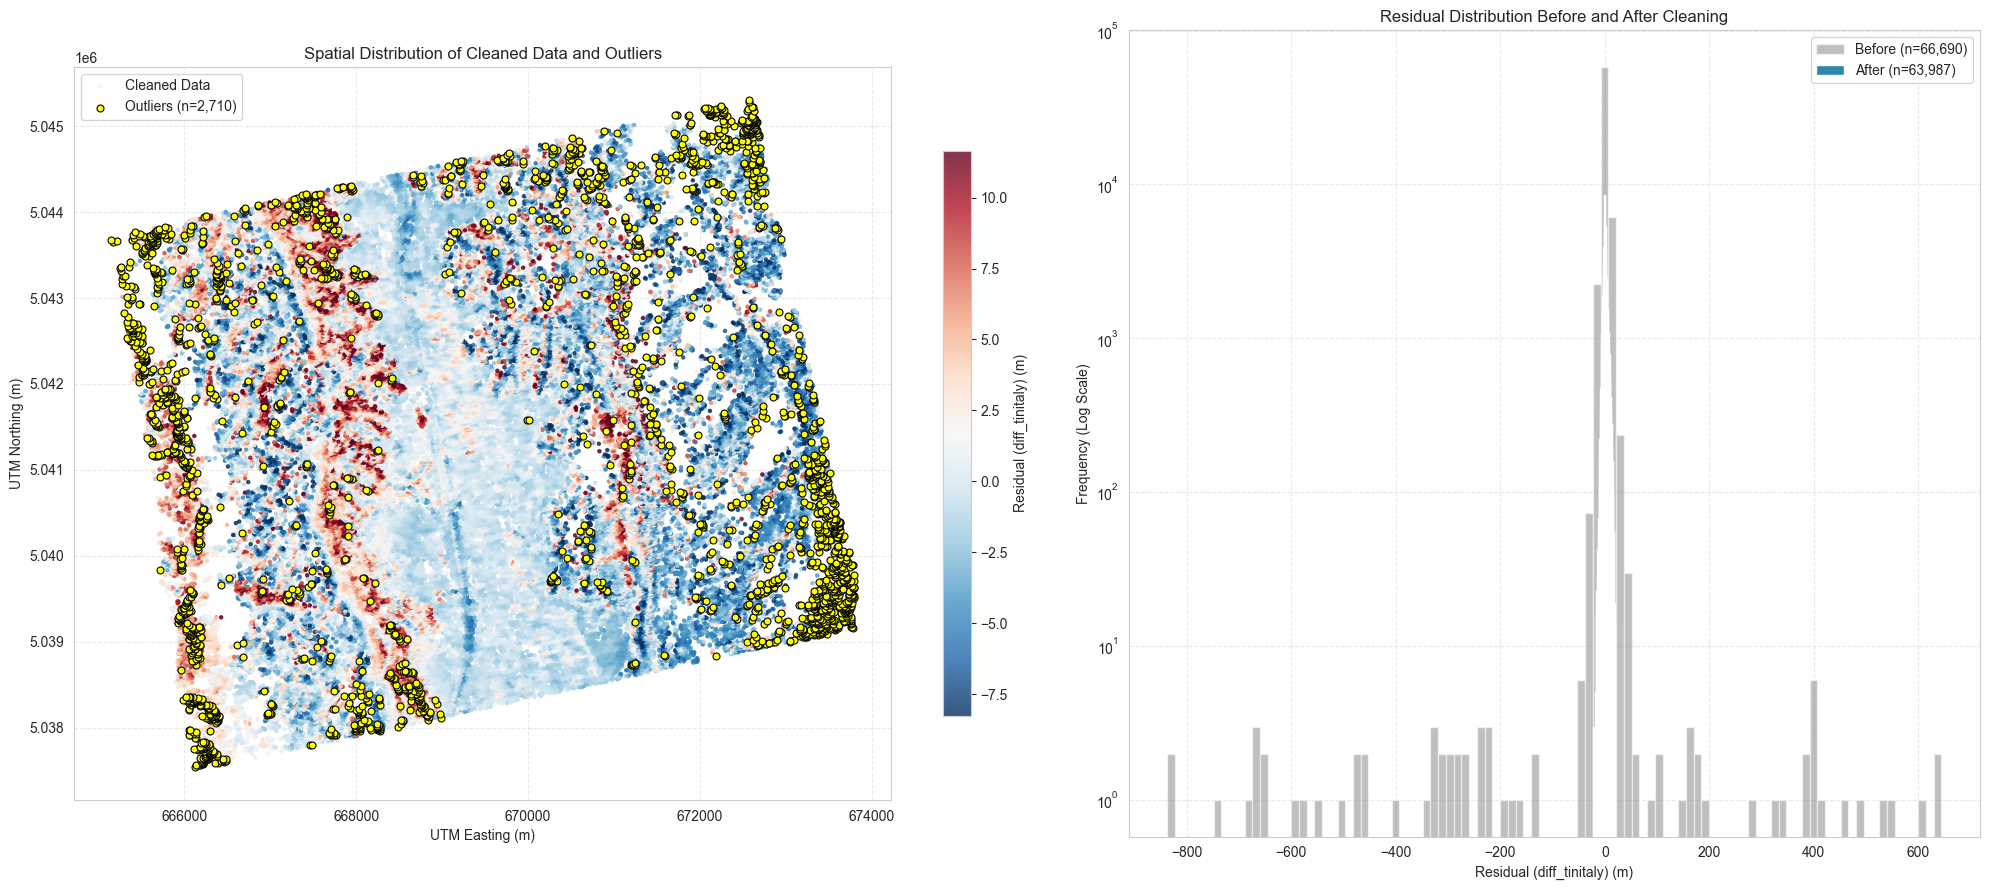


 STATISTICAL SUMMARY FOR: SAOCOM CLEANED (64055 points)

HEIGHT STATISTICS SUMMARY (m)
-----------------------------------------------------------------------------------------------
                           Dataset  Count    Min    Max   Mean  Median  Std Dev    Q25    Q75
         SAOCOM Cleaned (Relative)  64055  96.10 811.30 338.66  325.60   114.93 251.50 415.90
  TINITALY (at SAOCOM Cleaned pts)  63987  99.32 818.63 342.37  328.67   114.98 255.76 418.17
Copernicus (at SAOCOM Cleaned pts)  64055 100.09 822.32 343.78  330.14   115.35 256.48 420.80
-----------------------------------------------------------------------------------------------

DIFFERENCE STATISTICS (SAOCOM Relative - Reference DEM):
-----------------------------------------------------------------------------------------------

SAOCOM Cleaned - TINITALY:
  Mean: -3.916 m | Median: -4.390 m | Std: 4.383 m | RMSE: 5.877 m

SAOCOM Cleaned - Copernicus:
  Mean: -5.126 m | Median: -4.936 m | Std: 3.852 m | RMSE: 6.412 

In [14]:
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def score_outliers_isolation_forest(gdf: gpd.GeoDataFrame, residual_col: str, **kwargs) -> gpd.GeoDataFrame:
    """Add 'outlier_score' via Isolation Forest on (x,y,residual)."""
    if gdf.empty or residual_col not in gdf.columns:
        gdf = gdf.copy(); gdf['outlier_score'] = np.nan; return gdf
    pts = np.column_stack((gdf.geometry.x.values, gdf.geometry.y.values, gdf[residual_col].fillna(0).values))
    X = StandardScaler().fit_transform(pts)
    params = {'n_estimators':100, 'contamination':'auto', 'random_state':42, 'n_jobs':-1}
    params.update(kwargs)
    model = IsolationForest(**params).fit(X)
    gdf_scored = gdf.copy()
    gdf_scored['outlier_score'] = model.decision_function(X)
    return gdf_scored

def filter_by_score_iqr(gdf_scored: gpd.GeoDataFrame, iqr_multiplier: float = 1) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """Split into cleaned/outliers using IQR on 'outlier_score'."""
    if 'outlier_score' not in gdf_scored.columns:
        raise ValueError("Input GeoDataFrame must have an 'outlier_score' column.")
    s = gdf_scored['outlier_score'].values
    q1, q3 = np.percentile(s, [25, 75]); thr = q1 - iqr_multiplier*(q3 - q1)
    mask = s < thr
    return gdf_scored[~mask].copy(), gdf_scored[mask].copy()

def visualize_outlier_results(gdf_original: gpd.GeoDataFrame, gdf_cleaned: gpd.GeoDataFrame, outliers: gpd.GeoDataFrame, residual_col: str):
    """Two-panel: map (cleaned+outliers) and hist (before/after)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), facecolor='white', gridspec_kw={'width_ratios':[1.2,1]})
    vmin, vmax = np.nanpercentile(gdf_cleaned[residual_col].values, [2, 98])
    sc = ax1.scatter(gdf_cleaned.geometry.x.values, gdf_cleaned.geometry.y.values,
                     c=gdf_cleaned[residual_col].values, cmap='RdBu_r', s=5,
                     vmin=vmin, vmax=vmax, alpha=0.8, label='Cleaned Data')
    plt.colorbar(sc, ax=ax1, label=f'Residual ({residual_col}) (m)', shrink=0.7)
    if not outliers.empty:
        outliers.plot(ax=ax1, markersize=25, color='yellow', edgecolors='black', linewidth=0.8,
                      label=f'Outliers (n={len(outliers):,})', zorder=5)
    ax1.set(title='Spatial Distribution of Cleaned Data and Outliers', xlabel='UTM Easting (m)', ylabel='UTM Northing (m)')
    ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.4); ax1.set_aspect('equal', adjustable='box')

    orig = gdf_original[residual_col].dropna().values
    cln  = gdf_cleaned[residual_col].dropna().values
    ax2.hist(orig, bins=100, alpha=0.5, label=f'Before (n={orig.size:,})', color='gray')
    ax2.hist(cln,  bins=50,  alpha=1.0, label=f'After (n={cln.size:,})',  color='#2E86AB')
    ax2.set(title='Residual Distribution Before and After Cleaning', xlabel=f'Residual ({residual_col}) (m)', ylabel='Frequency (Log Scale)')
    ax2.set_yscale('log'); ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    fig.savefig(RESULTS_DIR / "difference_by_coherence.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Pipeline (unchanged semantics; less noise)
print(len(saocom_gdf))
saocom_gdf_scored = score_outliers_isolation_forest(saocom_gdf, 'diff_tinitaly')
saocom_gdf_cleaned, saocom_outliers = filter_by_score_iqr(saocom_gdf_scored)
visualize_outlier_results(saocom_gdf, saocom_gdf_cleaned, saocom_outliers, 'diff_tinitaly')
saocom_gdf = saocom_gdf_cleaned

def generate_height_statistics_summary(gdf, gdf_name="SAOCOM Data"):
    """Print compact height stats for HEIGHT_RELATIVE vs references."""
    need = ['HEIGHT_RELATIVE','tinitaly_height','copernicus_height']
    if not all(c in gdf.columns for c in need):
        print(f"Error: Input GeoDataFrame '{gdf_name}' is missing required height columns: {need}")
        return

    def _series_stats(s, name):
        v = s.dropna().values
        if v.size == 0: return None
        q25, q75 = np.percentile(v, [25, 75])
        return {'Dataset':name, 'Count':int(v.size), 'Min':float(v.min()), 'Max':float(v.max()),
                'Mean':float(v.mean()), 'Median':float(np.median(v)), 'Std Dev':float(v.std()),
                'Q25':float(q25), 'Q75':float(q75)}

    print("\n" + "="*95)
    print(f" STATISTICAL SUMMARY FOR: {gdf_name.upper()} ({len(gdf)} points)")
    print("="*95)

    rows = [
        _series_stats(gdf['HEIGHT_RELATIVE'], f'{gdf_name} (Relative)'),
        _series_stats(gdf['tinitaly_height'], f'TINITALY (at {gdf_name} pts)'),
        _series_stats(gdf['copernicus_height'], f'Copernicus (at {gdf_name} pts)')
    ]
    df = pd.DataFrame([r for r in rows if r is not None])
    print("\nHEIGHT STATISTICS SUMMARY (m)\n" + "-"*95)
    print(df.to_string(index=False, float_format=lambda x: f'{x:.2f}')); print("-"*95)

    def _diff_stats(a, b, label):
        d = (a - b).dropna().values
        if d.size == 0:
            print(f"\n{gdf_name} - {label}: No data."); return
        print(f"\n{gdf_name} - {label}:")
        print(f"  Mean: {d.mean():+.3f} m | Median: {np.median(d):+.3f} m | Std: {d.std():.3f} m | RMSE: {np.sqrt((d**2).mean()):.3f} m")

    print("\nDIFFERENCE STATISTICS (SAOCOM Relative - Reference DEM):\n" + "-"*95)
    _diff_stats(gdf['HEIGHT_RELATIVE'], gdf['tinitaly_height'], 'TINITALY')
    _diff_stats(gdf['HEIGHT_RELATIVE'], gdf['copernicus_height'], 'Copernicus')
    print("="*95)

# Summaries
generate_height_statistics_summary(saocom_gdf_cleaned, gdf_name="SAOCOM Cleaned")
generate_height_statistics_summary(saocom_outliers,   gdf_name="SAOCOM Outliers")
# generate_height_statistics_summary(saocom_gdf,        gdf_name="SAOCOM Original")


### 1. SPATIAL SAMPLE CORINE LAND COVER AT SAOCOM POINTS

In [15]:
```python
# --- Pre-req: residuals (SAOCOM calibrated to TINITALY)
saocom_gdf['diff_tinitaly'] = saocom_gdf['HEIGHT_ABSOLUTE_TIN'] - saocom_gdf['tinitaly_height']
# saocom_gdf['diff_copernicus'] = saocom_gdf['HEIGHT_ABSOLUTE_COP'] - saocom_gdf['copernicus_height']  # not needed here

# --- 1) Sample CORINE code at SAOCOM points (vectorized & bounds-safe)
xs, ys = saocom_gdf.geometry.x.values, saocom_gdf.geometry.y.values
r, c = rowcol(target_transform, xs, ys)
inb = (r>=0)&(r<grid_height)&(c>=0)&(c<grid_width)
codes = np.zeros(len(saocom_gdf), dtype=np.uint16)
codes[inb] = corine_10m[r[inb], c[inb]]
codes[codes == 255] = 0  # map nodata→0
saocom_gdf['corine_code'] = codes

# restrict to valid CORINE pixels
saocom_lc_analysis = saocom_gdf[saocom_gdf['corine_code'] != 0].copy()

# --- 2) Robust stats by land cover (NMAD etc.)
def nmad(x: np.ndarray) -> float:
    x = np.asarray(x)
    med = np.median(x)
    return 1.4826 * np.median(np.abs(x - med))

lc_height_stats = (
    saocom_lc_analysis
    .groupby('corine_code', as_index=False)['diff_tinitaly']
    .agg(
        N_Points='count',
        Median_Diff_m='median',
        Mean_Diff_m='mean',
        Std_Dev_m='std',
        NMAD_m=lambda s: nmad(s.dropna().values)
    )
)
lc_height_stats['LC_Label'] = lc_height_stats['corine_code'].map(CORINE_CLASSES)

MIN_SAMPLES = 50
lc_height_stats_filtered = (
    lc_height_stats[lc_height_stats['N_Points'] >= MIN_SAMPLES]
    .sort_values('LC_Label', ascending=True)
)

# --- 3) Display results (compact formatting)
print("\n" + "="*100)
print(f"HEIGHT RESIDUAL STATISTICS by CORINE Land Cover (N > {MIN_SAMPLES})")
print("(Residual = Calibrated SAOCOM Height - TINITALY Reference DEM)")
print("="*100)

disp_cols = ['corine_code','LC_Label','N_Points','Median_Diff_m','NMAD_m','Mean_Diff_m','Std_Dev_m']
fmt = {
    'N_Points': '{:,}'.format,
    'Median_Diff_m': '{:+.2f} m'.format,
    'NMAD_m': '{:.2f} m'.format,
    'Mean_Diff_m': '{:+.2f} m'.format,
    'Std_Dev_m': '{:.2f} m'.format
}
print(lc_height_stats_filtered[disp_cols].to_string(index=False, formatters=fmt))
print("="*100)

# keep for later use
lc_height_stats_final = lc_height_stats_filtered.copy()

# ====================== VOID ANALYSIS BY LAND COVER ======================

# globals assumed: corine_10m, study_area_mask, saocom_coverage, void_mask, GRID_SIZE, CORINE_CLASSES
n_total_cells = int(study_area_mask.sum())
n_void_cells  = int(void_mask.sum())
void_percentage_global = 100 * n_void_cells / n_total_cells if n_total_cells else 0.0

# Vectorized per-class counts inside study area
codes_sa = corine_10m[study_area_mask]                      # uint16 codes within hull
valid_mask_codes = codes_sa != 0
codes_valid = codes_sa[valid_mask_codes]

# total cells per LC code
max_code = int(codes_valid.max()) if codes_valid.size else 0
tot_counts = np.bincount(codes_valid, minlength=max_code+1)

# void cells per LC code (only where code!=0 inside hull)
void_codes = codes_sa[void_mask[study_area_mask]]
void_codes = void_codes[void_codes != 0]
void_counts = np.bincount(void_codes, minlength=max_code+1)

# Build DataFrame (exclude code 0)
idx = np.arange(max_code+1)
mask_has = tot_counts > 0
df = pd.DataFrame({
    'corine_code': idx[mask_has],
    'total_cells': tot_counts[mask_has].astype(np.int64),
    'void_cells':  void_counts[mask_has].astype(np.int64)
})
cell_area_km2 = (GRID_SIZE/1000.0)**2
df['Area_km2'] = df['total_cells'] * cell_area_km2
df['Pct_LC_is_Void']   = 100.0 * df['void_cells'] / df['total_cells']
df['Pct_of_Total_Voids'] = (100.0 * df['void_cells'] / n_void_cells) if n_void_cells else 0.0
df['label'] = df['corine_code'].map(CORINE_CLASSES).fillna(df['corine_code'].map(lambda x: f'Unknown_{x}'))

void_stats_df = df[['corine_code','label','total_cells','void_cells','Area_km2','Pct_LC_is_Void','Pct_of_Total_Voids']].copy()

# --- Display filtered summary
MIN_AREA_KM2 = 1.0
void_stats_filtered = (
    void_stats_df[void_stats_df['Area_km2'] >= MIN_AREA_KM2]
    .sort_values('Pct_LC_is_Void', ascending=False)
    .rename(columns={'total_cells':'total_cells'})  # preserve original naming
)

print("\n" + "="*120)
print(f"VOID ANALYSIS by CORINE Land Cover (Area > {MIN_AREA_KM2:.1f} km²)")
print(f"Overall Void Percentage (Study Area): {void_percentage_global:.2f}%")
print("="*120)

disp_cols_void = ['corine_code','label','Area_km2','void_cells','Pct_LC_is_Void','Pct_of_Total_Voids']
fmt_void = {
    'Area_km2': '{:.1f} km²'.format,
    'void_cells': '{:,}'.format,
    'Pct_LC_is_Void': '{:.2f} %'.format,
    'Pct_of_Total_Voids': '{:.2f} %'.format
}
print(void_stats_filtered[disp_cols_void].to_string(index=False, formatters=fmt_void))
print("="*120)

# keep for later use
lc_void_stats_final = void_stats_filtered.copy()
```


SyntaxError: invalid syntax (2524522005.py, line 1)

###  1. PREPARE DATA FOR PLOTTING

In [ ]:


# =============================================================================
# 1. PREPARE DATA FOR PLOTTING
# =============================================================================
# Use the full saocom_lc_analysis DataFrame which contains both the residuals
# ('diff_tinitaly') and the sampled land cover codes ('corine_code').

# Define major land cover groups for better visualization (CLC Level 1)
def get_clc_level1(code):
    """Maps CLC Level 3 code to Level 1 category"""
    if 100 <= code < 200: return '1. Artificial Surfaces'
    if 200 <= code < 300: return '2. Agricultural Areas'
    if 300 <= code < 400: return '3. Forest & Semi-Natural Areas'
    if 400 <= code < 500: return '4. Wetlands'
    if 500 <= code < 600: return '5. Water Bodies'
    return 'Other'

# Add Level 1 categories to the analysis DataFrame
saocom_lc_analysis['LC_Level_1'] = saocom_lc_analysis['corine_code'].apply(get_clc_level1)
saocom_lc_analysis['LC_Label'] = saocom_lc_analysis['corine_code'].map(CORINE_CLASSES)

# Filter for the most common Level 3 classes (using the N_Points filter from Step 1)
common_codes = lc_height_stats_final['corine_code'].unique()
plot_df_L3 = saocom_lc_analysis[saocom_lc_analysis['corine_code'].isin(common_codes)].copy()

# Filter extreme outliers for better plot scaling (e.g., 99th percentile)
q_low = plot_df_L3['diff_tinitaly'].quantile(0.005)
q_high = plot_df_L3['diff_tinitaly'].quantile(0.995)
plot_df_L3_filtered = plot_df_L3[(plot_df_L3['diff_tinitaly'] >= q_low) &
                                (plot_df_L3['diff_tinitaly'] <= q_high)]

# Sort the categories by the NMAD metric (best to worst performance)
nmad_order = lc_height_stats_final.sort_values('LC_Label', ascending=False)['LC_Label'].tolist()
plot_df_L3_filtered['LC_Label'] = pd.Categorical(
    plot_df_L3_filtered['LC_Label'],
    categories=nmad_order,
    ordered=True
)

q_low = plot_df_L3['diff_copernicus'].quantile(0.005)
q_high = plot_df_L3['diff_copernicus'].quantile(0.995)
plot_df_cop_filtered = plot_df_L3[(plot_df_L3['diff_copernicus'] >= q_low) &
                                (plot_df_L3['diff_copernicus'] <= q_high)]

# Sort the categories by the NMAD metric (best to worst performance)
nmad_order = lc_height_stats_final.sort_values('LC_Label', ascending=False)['LC_Label'].tolist()
plot_df_cop_filtered['LC_Label'] = pd.Categorical(
    plot_df_cop_filtered['LC_Label'],
    categories=nmad_order,
    ordered=True
)


### SENTINEL-2 RGB PREPARATION

In [ ]:
# =============================================================================
# SENTINEL-2 RGB PREPARATION
# =============================================================================

# File discovery
sentinel_files = list((DATA_DIR / "sentinel_data").glob("*.tif"))
if not sentinel_files:
    raise FileNotFoundError("No Sentinel files found in sentinel_data directory")

# Load Sentinel bands (assuming separate R, G, B files or multi-band)
with rasterio.open(sentinel_files[0]) as src:
    sentinel_count = src.count

    if sentinel_count >= 3:
        # Multi-band file - read RGB bands
        sentinel_r = src.read(1)  # Band 1 (Red)
        sentinel_g = src.read(2)  # Band 2 (Green)
        sentinel_b = src.read(3)  # Band 3 (Blue)
        sentinel_transform_orig = src.transform
        sentinel_crs = src.crs
    else:
        # Single band files - need to find R, G, B separately
        r_file = next((f for f in sentinel_files if 'B04' in f.name or 'red' in f.name.lower()), None)
        g_file = next((f for f in sentinel_files if 'B03' in f.name or 'green' in f.name.lower()), None)
        b_file = next((f for f in sentinel_files if 'B02' in f.name or 'blue' in f.name.lower()), None)

        if not all([r_file, g_file, b_file]):
            raise FileNotFoundError("Could not find RGB bands in Sentinel files")

        with rasterio.open(r_file) as r_src:
            sentinel_r = r_src.read(1)
            sentinel_transform_orig = r_src.transform
            sentinel_crs = r_src.crs
        with rasterio.open(g_file) as g_src:
            sentinel_g = g_src.read(1)
        with rasterio.open(b_file) as b_src:
            sentinel_b = b_src.read(1)

# Resample each band to 10m grid
sentinel_r_10m = np.zeros((grid_height, grid_width), dtype=np.float32)
sentinel_g_10m = np.zeros((grid_height, grid_width), dtype=np.float32)
sentinel_b_10m = np.zeros((grid_height, grid_width), dtype=np.float32)

for band_src, band_dst in [(sentinel_r, sentinel_r_10m),
                            (sentinel_g, sentinel_g_10m),
                            (sentinel_b, sentinel_b_10m)]:
    reproject(
        source=band_src,
        destination=band_dst,
        src_transform=sentinel_transform_orig,
        src_crs=sentinel_crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.bilinear
    )

# Stack into RGB array
sentinel_rgb = np.stack([sentinel_r_10m, sentinel_g_10m, sentinel_b_10m], axis=2)

# Mask to study area
sentinel_rgb[~hull_mask] = 0

# Normalize to 0-1 for display (using 2-98 percentile stretch for contrast)
sentinel_rgb_norm = np.zeros_like(sentinel_rgb, dtype=np.float32)
for i in range(3):
    band = sentinel_rgb[:, :, i]
    valid_pixels = band[hull_mask]

    if len(valid_pixels) > 0:
        p2, p98 = np.percentile(valid_pixels[valid_pixels > 0], [2, 98])
        band_norm = np.clip((band - p2) / (p98 - p2), 0, 1)
        sentinel_rgb_norm[:, :, i] = band_norm

print(f"\nSentinel-2 RGB Prepared:")
print(f"  Shape: {sentinel_rgb_norm.shape}")
print(f"  Resolution: {GRID_SIZE}m")
print(f"  Value range: [{sentinel_rgb_norm.min():.3f}, {sentinel_rgb_norm.max():.3f}]")

### 2. GENERATE VIOLIN PLOT (Level 3 - Detailed Performance)

In [ ]:
# =============================================================================
# 1. GENERATE STATS WITHIN THE PLOT SCRIPT
# =============================================================================
print("Generating statistics just-in-time for the plot...")

def calculate_nmad(series):
    """Calculates the Normalized Median Absolute Deviation (NMAD)."""
    return (series - series.median()).abs().median() * 1.4826

# Create a new, temporary stats DataFrame by grouping the plotting data
stats_for_plot = plot_df_L3_filtered.groupby('LC_Label')['diff_tinitaly'].agg(
    Median_Diff_m='median',
    NMAD_m=calculate_nmad,
    Std_Dev_m='std',
    Min_Diff_m='min',
    Max_Diff_m='max'
).reset_index()

# Determine the plotting order based on the NMAD we just calculated
nmad_order = stats_for_plot.sort_values('NMAD_m')['LC_Label'].tolist()

# Define an anchor point for the text annotations
q_high = plot_df_L3_filtered['diff_tinitaly'].quantile(0.99) + 5


# =============================================================================
# 2. GENERATE VIOLIN PLOT (Level 3 - Detailed Performance)
# =============================================================================
plt.figure(figsize=(16, 9), facecolor='white')

# Use violin plot, ordering it with the 'nmad_order' list we just created
sns.violinplot(
    x='diff_tinitaly',
    y='LC_Label',
    data=plot_df_L3_filtered,
    order=nmad_order,  # Use the calculated order here
    inner='quartile',
    palette='Spectral_r',
    orient='h',
    linewidth=1.0,
    cut=0
)

# Add a vertical line at zero error
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Set labels and title
plt.title('Distribution of SAOCOM Height Residuals by Land Cover (CLC Level 3)', fontweight='bold', fontsize=18)
plt.xlabel('Height Residual (Calibrated SAOCOM - TINITALY DEM) [m]', fontsize=14)
plt.ylabel('CORINE Land Cover Class (Ordered by NMAD)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# --- Add Annotations using the stats we just generated ---
for i, label in enumerate(nmad_order):
    # Query the 'stats_for_plot' DataFrame we created above
    stats = stats_for_plot.query("LC_Label == @label").iloc[0]

    stats_text = (
        f"Median: {stats['Median_Diff_m']:+.2f} m\n"
        f"NMAD: {stats['NMAD_m']:.2f} m\n"
        f"Std Dev: {stats['Std_Dev_m']:.2f} m\n"
        f"Min/Max: [{stats['Min_Diff_m']:.1f}, {stats['Max_Diff_m']:.1f}] m"
    )

    plt.text(q_high, i, stats_text,
             verticalalignment='center',
             horizontalalignment='left',
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
            )

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()
print("Violin Plot for Level 3 Land Cover classes generated successfully.")
# Add this line to save the figure
plt.savefig(RESULTS_DIR / 'saocom_tinitaly_residuals_by_landcover.png', dpi=300, bbox_inches='tight')

plt.show()

# =============================================================================
# COPERNICUS STATISTICS AND VIOLIN PLOT (Level 3)
# =============================================================================

print("Generating statistics for Copernicus plot...")

def calculate_nmad(series):
    """Calculates the Normalized Median Absolute Deviation (NMAD)."""
    return (series - series.median()).abs().median() * 1.4826

# Create a new stats DataFrame by grouping the filtered Copernicus plotting data
stats_for_cop_plot = plot_df_cop_filtered.groupby('LC_Label')['diff_copernicus'].agg(
    Median_Diff_m='median',
    NMAD_m=calculate_nmad,
    Std_Dev_m='std',
    Min_Diff_m='min',
    Max_Diff_m='max'
).reset_index()

# Determine the plotting order based on the NMAD we just calculated
nmad_order_cop = stats_for_cop_plot.sort_values('NMAD_m')['LC_Label'].tolist()

# Define an anchor point for the text annotations
q_high_cop = plot_df_cop_filtered['diff_copernicus'].quantile(0.995) + 5


# =============================================================================
# 2. GENERATE COPERNICUS VIOLIN PLOT (Level 3)
# =============================================================================
plt.figure(figsize=(16, 9), facecolor='white')

# Generate the violin plot, ordering it with the 'nmad_order_cop' list
sns.violinplot(
    x='diff_copernicus',
    y='LC_Label',
    data=plot_df_cop_filtered,
    order=nmad_order_cop,  # Use the calculated order here
    inner='quartile',
    palette='Spectral_r',
    orient='h',
    linewidth=1.0,
    cut=0
)

# Add a vertical line at zero error
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Set labels and title
plt.title('Distribution of SAOCOM Height Residuals by Land Cover (vs. Copernicus)', fontweight='bold', fontsize=18)
plt.xlabel('Height Residual (Calibrated SAOCOM - Copernicus DEM) [m]', fontsize=14)
plt.ylabel('CORINE Land Cover Class (Ordered by NMAD)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# --- Add Annotations using the stats we just generated ---
for i, label in enumerate(nmad_order_cop):
    # Query the 'stats_for_cop_plot' DataFrame
    stats = stats_for_cop_plot.query("LC_Label == @label").iloc[0]

    stats_text = (
        f"Median: {stats['Median_Diff_m']:+.2f} m\n"
        f"NMAD: {stats['NMAD_m']:.2f} m\n"
        f"Std Dev: {stats['Std_Dev_m']:.2f} m\n"
        f"Min/Max: [{stats['Min_Diff_m']:.1f}, {stats['Max_Diff_m']:.1f}] m"
    )

    plt.text(q_high_cop, i, stats_text,
             verticalalignment='center',
             horizontalalignment='left',
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
            )

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()
print("Violin Plot for Copernicus comparison generated successfully.")
# Add this line to save the figure
plt.savefig(RESULTS_DIR / 'saocom_copernicus_residuals_by_landcover.png', dpi=300, bbox_inches='tight')

plt.show()
# =============================================================================
# 3. GENERATE BOX PLOT (Level 1 - Broad Comparison)
# =============================================================================
plt.figure(figsize=(10, 6), facecolor='white')

# Use box plot for a cleaner Level 1 aggregation
sns.boxplot(
    x='LC_Level_1',
    y='diff_tinitaly',
    data=plot_df_L3_filtered,
    palette='Set2',
    linewidth=1.0,
    showfliers=False # Do not show outliers already filtered
)

# Add a horizontal line at zero error
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Set labels and title
plt.title(
    'SAOCOM Height Residuals by Land Cover (CLC Level 1)',
    fontweight='bold',
    fontsize=14
)
plt.xlabel('CORINE Land Cover Category (Level 1)', fontsize=11)
plt.ylabel('Height Residual (m)', fontsize=11)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print("Box Plot for Level 1 Land Cover categories generated successfully.")

# =============================================================================
# CORINE LAND COVER VISUALIZATION
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
ax.set_facecolor('white')

# Get extent
extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Mask NoData/zero values for transparency
corine_display = np.ma.masked_where((corine_10m == 0) | (corine_10m == 255), corine_10m)

# Get unique classes in study area
unique_codes = np.unique(corine_display.compressed())

# Create colormap for present classes only
colors_list = [CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5)) for code in unique_codes]
cmap = ListedColormap(colors_list)
norm = BoundaryNorm(boundaries=np.append(unique_codes, unique_codes[-1]+1) - 0.5,
                    ncolors=len(unique_codes))

# Plot CORINE
im = ax.imshow(corine_display, cmap=cmap, norm=norm, origin='upper', extent=extent)

# Add study area boundary
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Study Area')

# Labels and title
ax.set_xlabel('UTM Easting (m)', fontsize=14, color='black')
ax.set_ylabel('UTM Northing (m)', fontsize=14, color='black')
ax.set_title('CORINE Land Cover 2018', fontweight='bold', fontsize=18, color='black')
ax.tick_params(colors='black', labelsize=12)
ax.grid(True, alpha=0.3, linewidth=0.5, color='black')

# Create legend with only present classes
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=CORINE_COLORS_MPL[code],
                                 edgecolor='black', linewidth=0.5,
                                 label=f"{code}: {CORINE_CLASSES.get(code, 'Unknown')}")
                   for code in sorted(unique_codes)]

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
          fontsize=13, frameon=True, fancybox=False, edgecolor='black')

# Add scale bar
scalebar = ScaleBar(1, location='lower right', box_alpha=0.8, color='black')
ax.add_artist(scalebar)

# Add statistics box
total_area_km2 = np.sum(study_area_mask) * 0.0001
stats_text = f"Study Area: {total_area_km2:.2f} km²\nClasses: {len(unique_codes)}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white',
        alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.show()

print(f"\nCORINE Land Cover Map:")
print(f"  Total classes present: {len(unique_codes)}")
print(f"  Study area: {total_area_km2:.2f} km²")
## =============================================================================
# SAOCOM HEIGHT RESIDUALS - INTERPOLATED HEAT MAPS
# =============================================================================
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

fig, axes = plt.subplots(1, 2, figsize=(22, 10), facecolor='white')

extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Filter valid points
valid_tin = saocom_gdf[saocom_gdf['diff_tinitaly'].notna()].copy()
valid_cop = saocom_gdf[saocom_gdf['diff_copernicus'].notna()].copy()

# Calculate symmetric color limits (95th percentile)
tin_limit = np.percentile(np.abs(valid_tin['diff_tinitaly']), 95)
cop_limit = np.percentile(np.abs(valid_cop['diff_copernicus']), 95)
common_limit = max(tin_limit, cop_limit)

# Create interpolation grid (matching the 10m grid)
xi = np.linspace(xmin_grid, xmax_grid, grid_width)
yi = np.linspace(ymax_grid, ymin_grid, grid_height)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# =============================================================================
# Plot 1: SAOCOM - TINITALY Heat Map
# =============================================================================
ax = axes[0]
ax.set_facecolor('white')

# Background: Sentinel RGB (very faint)
ax.imshow(sentinel_rgb_norm, extent=extent, origin='upper', alpha=0.2)

# Extract coordinates and values
x_tin = valid_tin.geometry.x.values
y_tin = valid_tin.geometry.y.values
z_tin = valid_tin['diff_tinitaly'].values

# Interpolate to grid using cubic method
print("Interpolating TINITALY differences...")
zi_tin = griddata((x_tin, y_tin), z_tin, (xi_grid, yi_grid),
                  method='cubic', fill_value=np.nan)

# Apply Gaussian smoothing for smoother heat map
zi_tin_smooth = gaussian_filter(np.nan_to_num(zi_tin, nan=0), sigma=2)
zi_tin_smooth[~hull_mask] = np.nan  # Mask to study area

# Plot heat map
im1 = ax.imshow(zi_tin_smooth, extent=extent, origin='upper',
                cmap='RdBu_r', alpha=0.8,
                vmin=-common_limit, vmax=common_limit,
                interpolation='bilinear')

# Overlay original points (small, for reference)
ax.scatter(x_tin, y_tin, c=z_tin, cmap='RdBu_r',
           s=0.5, alpha=0.3, edgecolors='none',
           vmin=-common_limit, vmax=common_limit)

# Study area boundary
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, linestyle='--')

# Colorbar
cbar1 = plt.colorbar(im1, ax=ax, label='Height Difference (m)',
                     shrink=0.8, pad=0.02)
cbar1.ax.tick_params(labelsize=10, colors='black')
cbar1.ax.yaxis.label.set_color('black')

ax.set_xlabel('UTM Easting (m)', fontsize=12, color='black')
ax.set_ylabel('UTM Northing (m)', fontsize=12, color='black')
ax.set_title('SAOCOM - TINITALY\nInterpolated Height Residual Heat Map',
             fontweight='bold', fontsize=14, color='black')
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
ax.tick_params(colors='black')

# Statistics box
stats_text = f"""Points: {len(valid_tin):,}
Mean: {valid_tin['diff_tinitaly'].mean():+.2f} m
Median: {valid_tin['diff_tinitaly'].median():+.2f} m
RMSE: {np.sqrt((valid_tin['diff_tinitaly']**2).mean()):.2f} m
NMAD: {1.4826 * np.median(np.abs(valid_tin['diff_tinitaly'] - valid_tin['diff_tinitaly'].median())):.2f} m
Std: {valid_tin['diff_tinitaly'].std():.2f} m

Interpolation: Cubic + Gaussian
Color Scale: ±{common_limit:.1f} m
Red = SAOCOM Higher
Blue = TINITALY Higher"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9,
                 edgecolor='black'))

# =============================================================================
# Plot 2: SAOCOM - Copernicus Heat Map
# =============================================================================
ax = axes[1]
ax.set_facecolor('white')

# Background: Sentinel RGB (very faint)
ax.imshow(sentinel_rgb_norm, extent=extent, origin='upper', alpha=0.2)

# Extract coordinates and values
x_cop = valid_cop.geometry.x.values
y_cop = valid_cop.geometry.y.values
z_cop = valid_cop['diff_copernicus'].values

# Interpolate to grid using cubic method
print("Interpolating Copernicus differences...")
zi_cop = griddata((x_cop, y_cop), z_cop, (xi_grid, yi_grid),
                  method='cubic', fill_value=np.nan)

# Apply Gaussian smoothing
zi_cop_smooth = gaussian_filter(np.nan_to_num(zi_cop, nan=0), sigma=2)
zi_cop_smooth[~hull_mask] = np.nan  # Mask to study area

# Plot heat map
im2 = ax.imshow(zi_cop_smooth, extent=extent, origin='upper',
                cmap='RdBu_r', alpha=0.8,
                vmin=-common_limit, vmax=common_limit,
                interpolation='bilinear')

# Overlay original points (small, for reference)
ax.scatter(x_cop, y_cop, c=z_cop, cmap='RdBu_r',
           s=0.5, alpha=0.3, edgecolors='none',
           vmin=-common_limit, vmax=common_limit)

# Study area boundary
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, linestyle='--')

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax, label='Height Difference (m)',
                     shrink=0.8, pad=0.02)
cbar2.ax.tick_params(labelsize=10, colors='black')
cbar2.ax.yaxis.label.set_color('black')

ax.set_xlabel('UTM Easting (m)', fontsize=12, color='black')
ax.set_ylabel('UTM Northing (m)', fontsize=12, color='black')
ax.set_title('SAOCOM - Copernicus\nInterpolated Height Residual Heat Map',
             fontweight='bold', fontsize=14, color='black')
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
ax.tick_params(colors='black')

# Statistics box
stats_text = f"""Points: {len(valid_cop):,}
Mean: {valid_cop['diff_copernicus'].mean():+.2f} m
Median: {valid_cop['diff_copernicus'].median():+.2f} m
RMSE: {np.sqrt((valid_cop['diff_copernicus']**2).mean()):.2f} m
NMAD: {1.4826 * np.median(np.abs(valid_cop['diff_copernicus'] - valid_cop['diff_copernicus'].median())):.2f} m
Std: {valid_cop['diff_copernicus'].std():.2f} m

Interpolation: Cubic + Gaussian
Color Scale: ±{common_limit:.1f} m
Red = SAOCOM Higher
Blue = Copernicus Higher"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9,
                 edgecolor='black'))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'saocom_residual_heatmaps_interpolated.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nSaved: saocom_residual_heatmaps_interpolated.png")
print(f"Interpolation method: Cubic spline + Gaussian smoothing (sigma=2)")
print(f"Color scale range: ±{common_limit:.2f} m")



### Class Overlays Basic


### INDIVIDUAL CLASS OVERLAY MAPS (COLORBLIND-FRIENDLY)

In [ ]:
# =============================================================================
# INDIVIDUAL CLASS OVERLAY MAPS (COLORBLIND-FRIENDLY)
# =============================================================================
from matplotlib.patches import Patch

# Get unique classes present in data
unique_classes = np.unique(corine_10m[corine_10m > 0])

# Create one map per class
for lc_code in sorted(unique_classes):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10), facecolor='white')
    ax.set_facecolor('white')

    # Display Sentinel RGB as background
    ax.imshow(sentinel_rgb_norm, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
              origin='upper', alpha=0.7)  # Slight transparency to help overlay show

    # Get color for this land cover class
    fill_color = tuple(c/255 for c in CORINE_COLORS.get(lc_code, (128, 128, 128)))

    # Create mask for this land cover class
    lc_mask = (corine_10m == lc_code)

    # Vectorize to get boundaries
    mask_shapes = shapes(lc_mask.astype(np.uint8), mask=lc_mask, transform=target_transform)

    # Convert to polygons and plot
    polys = [shape(geom) for geom, val in mask_shapes if val == 1]

    if polys:
        for poly in polys:
            if poly.is_valid:
                x, y = poly.exterior.xy

                # Fill with class-specific color + hatching for visibility
                ax.fill(x, y, color=fill_color, alpha=0.4,
                       edgecolor='none', hatch='///', linewidth=0)

                # Bold black outline for definition
                ax.plot(x, y, color='black', linewidth=2.5, alpha=0.9)

                # Colored inner outline
                ax.plot(x, y, color=fill_color, linewidth=1.5, alpha=1.0)

    # Add study area boundary
    hull_gdf.boundary.plot(ax=ax, color='black', linewidth=3, linestyle='--', alpha=0.8)
    hull_gdf.boundary.plot(ax=ax, color='red', linewidth=1.5, linestyle='--', alpha=1.0)

    # Calculate statistics
    lc_count = np.sum(lc_mask)
    area_km2 = lc_count * (GRID_SIZE**2) / 1e6
    pct_area = 100 * lc_count / np.sum(corine_10m > 0)

    # Title with statistics
    class_name = CORINE_CLASSES.get(lc_code, f'Class {lc_code}')
    ax.set_title(f'Land Cover: {class_name}\n'
                 f'Code {lc_code} | Area: {area_km2:.1f} km² ({pct_area:.1f}%)',
                 fontweight='bold', fontsize=13, pad=15)

    ax.set_xlabel('UTM Easting (m)', fontsize=11)
    ax.set_ylabel('UTM Northing (m)', fontsize=11)
    ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)

    # Legend with hatching
    legend_elements = [
        Patch(facecolor=fill_color, edgecolor='black', linewidth=2,
              alpha=0.4, hatch='///', label=class_name),
        Patch(facecolor='none', edgecolor='red', linestyle='--',
              linewidth=2, label='Study Area')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10,
              frameon=True, fancybox=False, edgecolor='black')

    plt.tight_layout()

    # Save
    safe_name = class_name.replace(' ', '_').replace(',', '').replace('/', '_')
    filename = f'landcover_{lc_code}_{safe_name}.png'
    plt.savefig(RESULTS_DIR / filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

    print(f"Saved: {filename}")

print(f"\nGenerated {len(unique_classes)} individual land cover overlay maps")

### SAOCOM VS TINITALY COMPARISON

In [ ]:
# =============================================================================
# SAOCOM VS TINITALY COMPARISON
# =============================================================================
# Filter for valid comparisons with elevation range check
valid_elevation_range = (50, 850)

saocom_tinitaly_mask = (
    (saocom_gdf['HEIGHT_ABSOLUTE_TIN'].notna()) &
    (saocom_gdf['tinitaly_height'].notna()) &
    (saocom_gdf['HEIGHT_ABSOLUTE_TIN'] >= valid_elevation_range[0]) &
    (saocom_gdf['HEIGHT_ABSOLUTE_TIN'] <= valid_elevation_range[1]) &
    (saocom_gdf['COHER'] >= 0.5)
)
saocom_tinitaly_valid = saocom_gdf[saocom_tinitaly_mask]

saocom_tinitaly_diff = (saocom_tinitaly_valid['HEIGHT_ABSOLUTE_TIN'] -
                        saocom_tinitaly_valid['tinitaly_height']).values

saocom_tinitaly_metrics = {
    'n_points': int(len(saocom_tinitaly_diff)),
    'mean_diff': float(np.mean(saocom_tinitaly_diff)),
    'median_diff': float(np.median(saocom_tinitaly_diff)),
    'std_diff': float(np.std(saocom_tinitaly_diff)),
    'rmse': float(np.sqrt(np.mean(saocom_tinitaly_diff**2))),
    'mae': float(np.mean(np.abs(saocom_tinitaly_diff))),
    'nmad': float(1.4826 * np.median(np.abs(saocom_tinitaly_diff - np.median(saocom_tinitaly_diff)))),
    'min_diff': float(np.min(saocom_tinitaly_diff)),
    'max_diff': float(np.max(saocom_tinitaly_diff)),
    'correlation': float(np.corrcoef(saocom_tinitaly_valid['HEIGHT_ABSOLUTE_TIN'].values,
                                     saocom_tinitaly_valid['tinitaly_height'].values)[0, 1])
}

saocom_tinitaly_tolerance = float(saocom_tinitaly_metrics['nmad'])
saocom_tinitaly_higher_mask = saocom_tinitaly_diff > saocom_tinitaly_tolerance
saocom_tinitaly_lower_mask = saocom_tinitaly_diff < -saocom_tinitaly_tolerance
saocom_tinitaly_equal_mask = np.abs(saocom_tinitaly_diff) <= saocom_tinitaly_tolerance

saocom_tinitaly_higher_count = np.sum(saocom_tinitaly_higher_mask)
saocom_tinitaly_lower_count = np.sum(saocom_tinitaly_lower_mask)
saocom_tinitaly_equal_count = np.sum(saocom_tinitaly_equal_mask)

saocom_tinitaly_pct_higher = 100 * saocom_tinitaly_higher_count / len(saocom_tinitaly_diff)
saocom_tinitaly_pct_lower = 100 * saocom_tinitaly_lower_count / len(saocom_tinitaly_diff)
saocom_tinitaly_pct_equal = 100 * saocom_tinitaly_equal_count / len(saocom_tinitaly_diff)

# =============================================================================
# SAOCOM VS COPERNICUS COMPARISON
# =============================================================================
saocom_copernicus_mask = (
    (saocom_gdf['HEIGHT_ABSOLUTE_COP'].notna()) &
    (saocom_gdf['copernicus_height'].notna()) &
    (saocom_gdf['HEIGHT_ABSOLUTE_COP'] >= valid_elevation_range[0]) &
    (saocom_gdf['HEIGHT_ABSOLUTE_COP'] <= valid_elevation_range[1]) &
    (saocom_gdf['COHER'] >= 0.5)
)
saocom_copernicus_valid = saocom_gdf[saocom_copernicus_mask]

saocom_copernicus_diff = (saocom_copernicus_valid['HEIGHT_ABSOLUTE_COP'] -
                          saocom_copernicus_valid['copernicus_height']).values

saocom_copernicus_metrics = {
    'n_points': int(len(saocom_copernicus_diff)),
    'mean_diff': float(np.mean(saocom_copernicus_diff)),
    'median_diff': float(np.median(saocom_copernicus_diff)),
    'std_diff': float(np.std(saocom_copernicus_diff)),
    'rmse': float(np.sqrt(np.mean(saocom_copernicus_diff**2))),
    'mae': float(np.mean(np.abs(saocom_copernicus_diff))),
    'nmad': float(1.4826 * np.median(np.abs(saocom_copernicus_diff - np.median(saocom_copernicus_diff)))),
    'min_diff': float(np.min(saocom_copernicus_diff)),
    'max_diff': float(np.max(saocom_copernicus_diff)),
    'correlation': float(np.corrcoef(saocom_copernicus_valid['HEIGHT_ABSOLUTE_COP'].values,
                                     saocom_copernicus_valid['copernicus_height'].values)[0, 1])
}

saocom_copernicus_tolerance = float(saocom_copernicus_metrics['nmad'])
saocom_copernicus_higher_mask = saocom_copernicus_diff > saocom_copernicus_tolerance
saocom_copernicus_lower_mask = saocom_copernicus_diff < -saocom_copernicus_tolerance
saocom_copernicus_equal_mask = np.abs(saocom_copernicus_diff) <= saocom_copernicus_tolerance

saocom_copernicus_higher_count = int(np.sum(saocom_copernicus_higher_mask))
saocom_copernicus_lower_count = int(np.sum(saocom_copernicus_lower_mask))
saocom_copernicus_equal_count = int(np.sum(saocom_copernicus_equal_mask))

saocom_copernicus_pct_higher = float(100 * saocom_copernicus_higher_count / len(saocom_copernicus_diff))
saocom_copernicus_pct_lower = float(100 * saocom_copernicus_lower_count / len(saocom_copernicus_diff))
saocom_copernicus_pct_equal = float(100 * saocom_copernicus_equal_count / len(saocom_copernicus_diff))



    ### 3d model


In [ ]:
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Use the cleaned dataset and outliers from Isolation Forest
normal_sample_3d = saocom_gdf.sample(n=min(5000, len(saocom_gdf)), random_state=42)
outlier_sample_3d = saocom_outliers.sample(n=min(500, len(saocom_outliers)), random_state=42) if len(saocom_outliers) > 0 else saocom_outliers

# Create SAOCOM interpolated surface
saocom_valid = saocom_gdf[saocom_gdf['HEIGHT_ABSOLUTE_TIN'].notna()].copy()
x_saocom = saocom_valid.geometry.x.values
y_saocom = saocom_valid.geometry.y.values
z_saocom = saocom_valid['HEIGHT_ABSOLUTE_TIN'].values

# Create grid for surface
xi = np.linspace(xmin_grid, xmax_grid, 100)
yi = np.linspace(ymin_grid, ymax_grid, 100)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate SAOCOM surface
zi_saocom = griddata((x_saocom, y_saocom), z_saocom, (xi_grid, yi_grid),
                     method='linear', fill_value=np.nan)

# Downsample TINITALY surface
tinitaly_downsampled = tinitaly_10m[::10, ::10]
x_tin = np.linspace(xmin_grid, xmax_grid, tinitaly_downsampled.shape[1])
y_tin = np.linspace(ymax_grid, ymin_grid, tinitaly_downsampled.shape[0])
x_tin_grid, y_tin_grid = np.meshgrid(x_tin, y_tin)
tinitaly_downsampled = np.where(tinitaly_downsampled == NODATA, np.nan, tinitaly_downsampled)

# Create figure
fig = go.Figure()

# TINITALY Surface
fig.add_trace(go.Surface(
    x=x_tin_grid, y=y_tin_grid, z=tinitaly_downsampled,
    colorscale='Earth', name='TINITALY DEM', showscale=True,
    colorbar=dict(x=1.15, title='Elevation (m)'),
    visible=True, opacity=0.8,
    hovertemplate='X: %{x:.0f}<br>Y: %{y:.0f}<br>TINITALY: %{z:.1f}m<extra></extra>'
))

# SAOCOM Interpolated Surface
fig.add_trace(go.Surface(
    x=xi_grid, y=yi_grid, z=zi_saocom,
    colorscale='Viridis', name='SAOCOM Surface',
    showscale=False, visible=False, opacity=0.7,
    hovertemplate='X: %{x:.0f}<br>Y: %{y:.0f}<br>SAOCOM: %{z:.1f}m<extra></extra>'
))

# Normal SAOCOM Points
fig.add_trace(go.Scatter3d(
    x=normal_sample_3d.geometry.x, y=normal_sample_3d.geometry.y,
    z=normal_sample_3d['HEIGHT_ABSOLUTE_TIN'],
    mode='markers', name='SAOCOM Points',
    marker=dict(size=2, color=normal_sample_3d['diff_tinitaly'],
                colorscale='RdBu_r', cmin=-10, cmax=10,
                colorbar=dict(x=1.0, title='Residual (m)', len=0.5, y=0.25),
                showscale=True, line=dict(width=0)),
    text=[f"Residual: {r:+.2f}m<br>Height: {h:.1f}m<br>Coherence: {c:.2f}"
          for r, h, c in zip(normal_sample_3d['diff_tinitaly'],
                            normal_sample_3d['HEIGHT_ABSOLUTE_TIN'],
                            normal_sample_3d['COHER'])],
    hovertemplate='%{text}<extra></extra>', visible=True
))

# Outlier Points
if len(outlier_sample_3d) > 0:
    fig.add_trace(go.Scatter3d(
        x=outlier_sample_3d.geometry.x, y=outlier_sample_3d.geometry.y,
        z=outlier_sample_3d['HEIGHT_ABSOLUTE_TIN'],
        mode='markers', name='Outliers',
        marker=dict(size=6, color='red', symbol='diamond',
                   line=dict(color='black', width=1)),
        text=[f"<b>OUTLIER</b><br>Residual: {r:+.2f}m<br>Height: {h:.1f}m<br>Coherence: {c:.2f}"
              for r, h, c in zip(outlier_sample_3d['diff_tinitaly'],
                                outlier_sample_3d['HEIGHT_ABSOLUTE_TIN'],
                                outlier_sample_3d['COHER'])],
        hovertemplate='%{text}<extra></extra>', visible=True
    ))

# Layout
fig.update_layout(
    updatemenus=[
        dict(type="buttons", direction="down", x=0.02, xanchor="left",
             y=0.98, yanchor="top",
             buttons=[
                 dict(label="All", method="update",
                      args=[{"visible": [True, True, True, True]}]),
                 dict(label="Surfaces Only", method="update",
                      args=[{"visible": [True, True, False, False]}]),
                 dict(label="Points Only", method="update",
                      args=[{"visible": [False, False, True, True]}]),
                 dict(label="TINITALY + Points", method="update",
                      args=[{"visible": [True, False, True, True]}]),
                 dict(label="SAOCOM Surface + Outliers", method="update",
                      args=[{"visible": [False, True, False, True]}]),
             ]),
        dict(type="buttons", direction="right", x=0.02, xanchor="left",
             y=0.02, yanchor="bottom",
             buttons=[
                 dict(label="Toggle TINITALY", method="restyle",
                      args=["visible", "toggle"], args2=[{"visible": [True]}, [0]]),
                 dict(label="Toggle SAOCOM Surface", method="restyle",
                      args=["visible", "toggle"], args2=[{"visible": [True]}, [1]]),
                 dict(label="Toggle Points", method="restyle",
                      args=["visible", "toggle"], args2=[{"visible": [True]}, [2]]),
                 dict(label="Toggle Outliers", method="restyle",
                      args=["visible", "toggle"], args2=[{"visible": [True]}, [3]]),
             ])
    ],
    scene=dict(xaxis_title='UTM Easting (m)', yaxis_title='UTM Northing (m)',
               zaxis_title='Elevation (m)', aspectmode='manual',
               aspectratio=dict(x=1, y=1, z=0.3),
               camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))),
    title=dict(text='3D SAOCOM vs TINITALY Analysis<br><sub>Top: Presets | Bottom: Toggle layers</sub>',
               x=0.5, xanchor='center'),
    width=1400, height=900, showlegend=True,
    legend=dict(x=0.02, y=0.5),
    paper_bgcolor='white', plot_bgcolor='white'
)

fig.write_html(RESULTS_DIR / 'saocom_3d_interactive.html')
print(f"Saved: {RESULTS_DIR / 'saocom_3d_interactive.html'}")
fig.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Note: This script assumes the following variables are pre-defined from previous cells:
# saocom_gdf, COHERENCE_THRESHOLD, hull_mask, hull_gdf, grid_height, grid_width,
# target_transform, xmin_grid, xmax_grid, ymin_grid, ymax_grid,
# saocom_tinitaly_metrics, saocom_copernicus_metrics, RESULTS_DIR

def create_difference_grid(gdf, height_col, ref_col, grid_shape, transform, hull_mask):
    """Grids point data differences onto a raster grid using nearest neighbor interpolation."""
    query_str = f"`{height_col}`.notna() & `{ref_col}`.notna() & COHER >= @COHERENCE_THRESHOLD"
    valid_points = gdf.query(query_str).copy()
    valid_points['diff'] = valid_points[height_col] - valid_points[ref_col]

    if valid_points.empty:
        return np.full(grid_shape, np.nan), valid_points

    # Create grid coordinates for interpolation
    grid_height, grid_width = grid_shape
    x_coords = np.linspace(transform.c, transform.c + transform.a * grid_width, grid_width)
    y_coords = np.linspace(transform.f, transform.f + transform.e * grid_height, grid_height)
    xi_grid, yi_grid = np.meshgrid(x_coords, y_coords)

    # Interpolate and mask the grid
    diff_grid = griddata(
        (valid_points.geometry.x, valid_points.geometry.y),
        valid_points['diff'],
        (xi_grid, yi_grid),
        method='nearest'
    )
    diff_grid[~hull_mask] = np.nan
    return diff_grid, valid_points

def plot_panel(ax, data, title, cmap, vmin=None, vmax=None, stats_text=None):
    """Helper function to plot a single map panel."""
    ax.set_facecolor('white')
    cmap.set_bad(color='white', alpha=0)
    extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]
    im = ax.imshow(data, cmap=cmap, origin='upper', extent=extent, vmin=vmin, vmax=vmax)
    hull_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('UTM Easting (m)')
    ax.set_ylabel('UTM Northing (m)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(im, ax=ax, label='Difference (m)', shrink=0.8)
    if stats_text:
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# --- Main Execution ---
print("Gridding SAOCOM differences (using cleaned data)...")
diff_grid_tin, points_tin = create_difference_grid(saocom_gdf, 'HEIGHT_ABSOLUTE_TIN', 'tinitaly_height', (grid_height, grid_width), target_transform, hull_mask)
diff_grid_cop, points_cop = create_difference_grid(saocom_gdf, 'HEIGHT_ABSOLUTE_COP', 'copernicus_height', (grid_height, grid_width), target_transform, hull_mask)

# --- Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(20, 14), facecolor='white')
fig.suptitle('SAOCOM vs. Reference DEMs - Gridded Difference Analysis', fontsize=16, fontweight='bold')

# Plotting parameters
v_tin = np.nanpercentile(np.abs(points_tin['diff']), 98)
v_cop = np.nanpercentile(np.abs(points_cop['diff']), 98)
stats_tin = f"n = {len(points_tin):,}\nMean = {points_tin['diff'].mean():+.2f} m\nRMSE = {np.sqrt(np.mean(points_tin['diff']**2)):.2f} m"
stats_cop = f"n = {len(points_cop):,}\nMean = {points_cop['diff'].mean():+.2f} m\nRMSE = {np.sqrt(np.mean(points_cop['diff']**2)):.2f} m"

# Row 1: SAOCOM vs TINITALY
plot_panel(axes[0, 0], diff_grid_tin, 'SAOCOM - TINITALY\nFull Difference', plt.cm.coolwarm, -v_tin, v_tin, stats_tin)
plot_panel(axes[0, 1], np.where(diff_grid_tin > 0, diff_grid_tin, np.nan), 'SAOCOM > TINITALY', plt.cm.Reds, 0, v_tin)
plot_panel(axes[0, 2], np.where(diff_grid_tin < 0, diff_grid_tin, np.nan), 'TINITALY > SAOCOM', plt.cm.Blues_r, -v_tin, 0)

# Row 2: SAOCOM vs Copernicus
plot_panel(axes[1, 0], diff_grid_cop, 'SAOCOM - Copernicus\nFull Difference', plt.cm.coolwarm, -v_cop, v_cop, stats_cop)
plot_panel(axes[1, 1], np.where(diff_grid_cop > 0, diff_grid_cop, np.nan), 'SAOCOM > Copernicus', plt.cm.Reds, 0, v_cop)
plot_panel(axes[1, 2], np.where(diff_grid_cop < 0, diff_grid_cop, np.nan), 'Copernicus > SAOCOM', plt.cm.Blues_r, -v_cop, 0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(RESULTS_DIR / 'saocom_gridded_comparison.png', dpi=300, facecolor='white')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Note: This script assumes the following variables are pre-defined from previous cells:
# saocom_gdf, COHERENCE_THRESHOLD, hull_gdf, saocom_tinitaly_metrics,
# saocom_copernicus_metrics, RESULTS_DIR, xmin_grid, xmax_grid, ymin_grid, ymax_grid

# =============================================================================
# Helper function for plotting points (Unchanged)
# =============================================================================
def plot_points_panel(ax, data, title, cmap, vmin=None, vmax=None, stats_text=None):
    """Helper function to plot a single map panel using a scatter plot."""
    ax.set_facecolor('gainsboro')

    im = ax.scatter(data.geometry.x, data.geometry.y, c=data['diff'],
                    s=1, alpha=0.7, cmap=cmap, vmin=vmin, vmax=vmax)

    hull_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('UTM Easting (m)')
    ax.set_ylabel('UTM Northing (m)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(im, ax=ax, label='Difference (m)', shrink=0.8)
    if stats_text:
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# =============================================================================
# Data preparation (Unchanged)
# =============================================================================
print("Filtering SAOCOM differences for plotting...")

query_str_tin = f"`HEIGHT_ABSOLUTE_TIN`.notna() & `tinitaly_height`.notna() & COHER >= @COHERENCE_THRESHOLD"
points_tin = saocom_gdf.query(query_str_tin).copy()
points_tin['diff'] = points_tin['HEIGHT_ABSOLUTE_TIN'] - points_tin['tinitaly_height']

query_str_cop = f"`HEIGHT_ABSOLUTE_COP`.notna() & `copernicus_height`.notna() & COHER >= @COHERENCE_THRESHOLD"
points_cop = saocom_gdf.query(query_str_cop).copy()
points_cop['diff'] = points_cop['HEIGHT_ABSOLUTE_COP'] - points_cop['copernicus_height']


# --- Visualization ---
# =============================================================================
# MODIFIED: Change subplot layout from (2, 3) to (3, 2) and adjust figsize
# =============================================================================
fig, axes = plt.subplots(3, 2, figsize=(14, 20), facecolor='white')
fig.suptitle('SAOCOM vs. Reference DEMs - Point-Based Difference Analysis', fontsize=16, fontweight='bold')

# Plotting parameters (Unchanged)
v_tin = np.nanpercentile(np.abs(points_tin['diff']), 98)
v_cop = np.nanpercentile(np.abs(points_cop['diff']), 98)
stats_tin = f"n = {len(points_tin):,}\nMean = {points_tin['diff'].mean():+.2f} m\nRMSE = {np.sqrt(np.mean(points_tin['diff']**2)):.2f} m"
stats_cop = f"n = {len(points_cop):,}\nMean = {points_cop['diff'].mean():+.2f} m\nRMSE = {np.sqrt(np.mean(points_cop['diff']**2)):.2f} m"

# =============================================================================
# MODIFIED: Update axes indexing for the new 3x2 layout
# =============================================================================
# Row 1: Full Difference Maps
plot_points_panel(axes[0, 0], points_tin, 'SAOCOM - TINITALY\nFull Difference', plt.cm.coolwarm, -v_tin, v_tin, stats_tin)
plot_points_panel(axes[0, 1], points_cop, 'SAOCOM - Copernicus\nFull Difference', plt.cm.coolwarm, -v_cop, v_cop, stats_cop)

# Row 2: SAOCOM > Reference DEM
plot_points_panel(axes[1, 0], points_tin[points_tin['diff'] > 0], 'SAOCOM > TINITALY', plt.cm.Reds, 0, v_tin)
plot_points_panel(axes[1, 1], points_cop[points_cop['diff'] > 0], 'SAOCOM > Copernicus', plt.cm.Reds, 0, v_cop)

# Row 3: Reference DEM > SAOCOM
plot_points_panel(axes[2, 0], points_tin[points_tin['diff'] < 0], 'TINITALY > SAOCOM', plt.cm.Blues_r, -v_tin, 0)
plot_points_panel(axes[2, 1], points_cop[points_cop['diff'] < 0], 'Copernicus > SAOCOM', plt.cm.Blues_r, -v_cop, 0)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(RESULTS_DIR / 'saocom_point_comparison_3x2.png', dpi=300, facecolor='white')
plt.show()

### Edited Histograms



In [ ]:
def plot_distribution(ax, diff_series, title, metrics):
    """Helper function to plot a single residual distribution histogram."""
    ax.set_facecolor('white')
    ax.hist(diff_series, bins=50, alpha=0.75, color='steelblue', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.axvline(metrics['mean_diff'], color='green', linestyle='-', label=f"Mean: {metrics['mean_diff']:+.2f}m")

    stats_text = (f"n = {metrics['n_points']:,}\n"
                  f"RMSE = {metrics['rmse']:.2f} m\n"
                  f"NMAD = {metrics['nmad']:.2f} m\n"
                  f"Std Dev = {metrics['std_diff']:.2f} m")

    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('Elevation Difference (m)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')
fig.suptitle('Residual Distributions (Cleaned Data)', fontsize=16, fontweight='bold')

# Use the 'diff' column from the points DataFrames created in the previous cell
plot_distribution(axes[0], points_tin['diff'], 'SAOCOM - TINITALY', saocom_tinitaly_metrics)
plot_distribution(axes[1], points_cop['diff'], 'SAOCOM - Copernicus', saocom_copernicus_metrics)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(RESULTS_DIR / 'saocom_residual_distributions.png', dpi=300, facecolor='white')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_comparison(ax, x_data, y_data, x_label, y_label, title, stats):
    """
    Creates a simple 1:1 scatter plot to compare two sets of height data.
    """
    ax.set_facecolor('white') # Set background to white

    # Plot the individual data points
    ax.scatter(x_data, y_data, s=1, alpha=0.3, c='steelblue', label='Data Points')

    # Determine plot limits and draw the 1:1 line
    lims = [
        np.min([x_data.min(), y_data.min()]),
        np.max([x_data.max(), y_data.max()]),
    ]
    ax.plot(lims, lims, 'r--', linewidth=2, label='1:1 Line', zorder=10)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Add statistics box
    stats_text = (f"n = {stats.get('n_points', stats.get('n_pixels')):,}\n"
                  f"Bias = {stats['mean_diff']:.2f} m\n"
                  f"RMSE = {stats['rmse']:.2f} m\n"
                  f"Corr (r) = {stats['correlation']:.3f}")

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', color='black', # Text color to black
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='black'))

    # Style the plot
    ax.set_title(title, fontweight='bold', fontsize=12, color='black')
    ax.set_xlabel(x_label, fontsize=11, color='black')
    ax.set_ylabel(y_label, fontsize=11, color='black')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    ax.set_aspect('equal', 'box')

    # Style ticks and spines
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')


# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(22, 7), facecolor='white')
fig.suptitle('1:1 Height Comparison Scatter Plots (Cleaned Data)', fontsize=16, fontweight='bold', color='black')

# Note: Assumes variables from previous cells are available
# (points_tin, points_cop, valid_copernicus, valid_tinitaly, and all metrics dicts)

plot_scatter_comparison(axes[0], points_tin['tinitaly_height'], points_tin['HEIGHT_ABSOLUTE_TIN'],
                        'TINITALY Height (m)', 'SAOCOM Height (m)', 'SAOCOM vs TINITALY', saocom_tinitaly_metrics)

plot_scatter_comparison(axes[1], points_cop['copernicus_height'], points_cop['HEIGHT_ABSOLUTE_COP'],
                        'Copernicus Height (m)', 'SAOCOM Height (m)', 'SAOCOM vs Copernicus', saocom_copernicus_metrics)

plot_scatter_comparison(axes[2], valid_copernicus, valid_tinitaly,
                        'Copernicus Height (m)', 'TINITALY Height (m)', 'TINITALY vs Copernicus', ref_metrics)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(RESULTS_DIR / 'saocom_scatter_comparisons.png', dpi=300, facecolor='white')
plt.show()

### Density Plots Color


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), facecolor='white')
fig.suptitle('1:1 Height Comparison - High-Contrast Hexbin Density Plots', fontsize=16, fontweight='bold')

def plot_hexbin(ax, x_data, y_data, x_label, y_label, title):
    """Helper function to create a hexbin plot with improved contrast."""
    ax.set_facecolor('gainsboro')

    # Create the hexbin plot
    # CHANGE 1: Switched to 'inferno' colormap for a high-contrast, "hotter" look.
    # Other good options are 'plasma' or 'magma'.
    hb = ax.hexbin(x_data, y_data, gridsize=150, cmap='inferno',
                   norm=colors.LogNorm(), mincnt=1) # Log scale is essential

    # Add a color bar
    fig.colorbar(hb, ax=ax, label='Point Count')

    # CHANGE 2: Switched 1:1 line to red for better visibility against the colormap.
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', linewidth=2, label='1:1 line', alpha=0.9)

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.grid(True, alpha=0.2)
    ax.legend()
    ax.set_aspect('equal', 'box')

# This is an alternative function you can use instead of plot_hexbin for a different style.
def plot_hist2d(ax, x_data, y_data, x_label, y_label, title):
    """Alternative helper function to create a 2D histogram (square bins)."""
    ax.set_facecolor('gainsboro')

    # Create the 2D histogram
    # Bins determines the resolution. Cmin=1 ensures empty bins are not colored.
    h = ax.hist2d(x_data, y_data, bins=150, cmap='inferno',
                  norm=colors.LogNorm(), cmin=1)

    # Add a color bar
    fig.colorbar(h[3], ax=ax, label='Point Count')

    # Add 1:1 line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'w--', linewidth=1.5, label='1:1 line', alpha=0.7) # White line works well here

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.grid(True, alpha=0.2)
    ax.legend()
    ax.set_aspect('equal', 'box')

# Plot 1: SAOCOM vs TINITALY
plot_hexbin(axes[0], points_tin['tinitaly_height'], points_tin['HEIGHT_ABSOLUTE_TIN'],
            'TINITALY Height (m)', 'SAOCOM Height (m)', 'SAOCOM vs TINITALY')

# Plot 2: SAOCOM vs Copernicus
plot_hexbin(axes[1], points_cop['copernicus_height'], points_cop['HEIGHT_ABSOLUTE_COP'],
            'Copernicus Height (m)', 'SAOCOM Height (m)', 'SAOCOM vs Copernicus')

# Plot 3: TINITALY vs Copernicus
plot_hexbin(axes[2], valid_copernicus, valid_tinitaly,
            'Copernicus Height (m)', 'TINITALY Height (m)', 'TINITALY vs Copernicus')

# To use the 2D histogram instead, you would replace the calls above with:
# plot_hist2d(axes[0], ...)
# plot_hist2d(axes[1], ...)
# plot_hist2d(axes[2], ...)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(RESULTS_DIR / 'saocom_hexbin_comparisons_high_contrast.png', dpi=300, facecolor='white')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), facecolor='white')
fig.suptitle('1:1 Height Comparison - Bland-Altman Density Plots', fontsize=16, fontweight='bold')

def plot_bland_altman(ax, x_data, y_data, x_label, y_label, title):
    """Helper function to create a Bland-Altman hexbin plot."""
    # --- Data Transformation ---
    # Calculate the average and difference
    average = (x_data + y_data) / 2
    difference = y_data - x_data

    # Calculate key statistics for the plot
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    limit_of_agreement = 1.96 * std_diff

    ax.set_facecolor('gainsboro')
    # Create the hexbin plot using the transformed data
    hb = ax.hexbin(average, difference, gridsize=150, cmap='viridis',
                   norm=colors.LogNorm(), mincnt=1)

    # Add a color bar
    fig.colorbar(hb, ax=ax, label='Point Count')

    # --- Add Statistical Lines ---
    # Line of perfect agreement (zero difference)
    ax.axhline(0, color='white', linestyle='--', linewidth=1.5, label='Zero (Perfect Agreement)')
    # Mean difference line
    ax.axhline(mean_diff, color='red', linestyle='-', linewidth=2, label=f'Mean Diff: {mean_diff:.2f} m')
    # Limits of agreement lines (+/- 1.96 * SD)
    ax.axhline(mean_diff + limit_of_agreement, color='red', linestyle='--', linewidth=1.5, label=f'Limits of Agreement (±{limit_of_agreement:.2f} m)')
    ax.axhline(mean_diff - limit_of_agreement, color='red', linestyle='--', linewidth=1.5)

    ax.set_title(title, fontweight='bold', fontsize=12)
    # Update axis labels for the new plot type
    ax.set_xlabel(f'Average of ({x_label} and {y_label})', fontsize=11)
    ax.set_ylabel(f'Difference ({y_label} - {x_label})', fontsize=11)
    ax.grid(True, alpha=0.2)
    ax.legend()

# Plot 1: SAOCOM vs TINITALY
plot_bland_altman(axes[0], points_tin['tinitaly_height'], points_tin['HEIGHT_ABSOLUTE_TIN'],
                  'SAOCOM', 'TINITALY', 'SAOCOM vs TINITALY')

# Plot 2: SAOCOM vs Copernicus
plot_bland_altman(axes[1], points_cop['copernicus_height'], points_cop['HEIGHT_ABSOLUTE_COP'],
                  'SAOCOM', 'Copernicus', 'SAOCOM vs Copernicus')

# Plot 3: TINITALY vs Copernicus
plot_bland_altman(axes[2], valid_copernicus, valid_tinitaly,
                  'TINITALY', 'Copernicus', 'TINITALY vs Copernicus')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(RESULTS_DIR / 'saocom_bland_altman_comparisons.png', dpi=300, facecolor='white')
plt.show()

### SAOCOM VS REFERENCE DEMs - GRIDDED COMPARISON ANALYSIS

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from scipy import stats
#
# # =============================================================================
# # 1. GRIDDED DEM COMPARISON
# # =============================================================================
#
# def process_dem_comparison(gdf, height_col, ref_col, grid_shape, transform, hull_mask, metrics):
#     """Grids SAOCOM point differences and classifies them against a tolerance."""
#     # Filter for valid, coherent points and calculate difference
#     valid_mask = gdf[height_col].notna() & gdf[ref_col].notna() & (gdf['COHER'] >= COHERENCE_THRESHOLD)
#     points = gdf[valid_mask].copy()
#     points['diff'] = points[height_col] - points[ref_col]
#
#     # Interpolate difference onto a grid
#     grid_height, grid_width = grid_shape
#     xi, yi = np.meshgrid(
#         np.linspace(transform.c, transform.c + transform.a * grid_width, grid_width),
#         np.linspace(transform.f, transform.f + transform.e * grid_height, grid_height)
#     )
#     diff_grid = griddata(
#         (points.geometry.x, points.geometry.y), points['diff'],
#         (xi, yi), method='nearest'
#     )
#     diff_grid[~hull_mask] = np.nan # Apply hull mask
#
#     # Classify differences based on NMAD tolerance
#     tolerance = metrics['nmad']
#     with np.errstate(invalid='ignore'): # Ignore warnings from comparing with NaN
#         higher_mask = diff_grid > tolerance
#         lower_mask = diff_grid < -tolerance
#
#     # Generate statistics
#     n_valid = np.count_nonzero(~np.isnan(diff_grid))
#     stats_dict = {
#         'n_total': n_valid,
#         'n_higher': np.sum(higher_mask), 'pct_higher': 100 * np.sum(higher_mask) / n_valid,
#         'n_lower': np.sum(lower_mask), 'pct_lower': 100 * np.sum(lower_mask) / n_valid,
#     }
#     return diff_grid, higher_mask, lower_mask, stats_dict, points
#
# def plot_gridded_comparison(axes, data, title, cmap, vmin=None, vmax=None, stats_text=None):
#     """Helper function to plot a single difference map."""
#     ax = axes
#     ax.set_facecolor('white')
#     cmap.set_bad(color='white', alpha=0)
#     im = ax.imshow(data, cmap=cmap, origin='upper', extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid], vmin=vmin, vmax=vmax)
#     hull_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
#     plt.colorbar(im, ax=ax, label='Difference (m)', shrink=0.8)
#     ax.set_title(title, fontweight='bold', fontsize=12)
#     ax.set_xlabel('UTM Easting (m)')
#     ax.set_ylabel('UTM Northing (m)')
#     ax.grid(True, alpha=0.3)
#     if stats_text:
#         ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, va='top',
#                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, ec='black'))
#
# # --- Main Plotting Logic for Gridded Comparison ---
# fig, axes = plt.subplots(2, 3, figsize=(20, 14), facecolor='white')
#
# # Define datasets to compare
# comparisons = [
#     {'name': 'TINITALY', 'h_col': 'HEIGHT_ABSOLUTE_TIN', 'r_col': 'tinitaly_height', 'metrics': saocom_tinitaly_metrics},
#     {'name': 'Copernicus', 'h_col': 'HEIGHT_ABSOLUTE_COP', 'r_col': 'copernicus_height', 'metrics': saocom_copernicus_metrics}
# ]
#
# for i, p in enumerate(comparisons):
#     diff_grid, higher, lower, stats, points = process_dem_comparison(
#         saocom_gdf, p['h_col'], p['r_col'], (grid_height, grid_width), target_transform, hull_mask, p['metrics']
#     )
#
#     # Plot 1: Full Difference
#     diff_limit = np.percentile(np.abs(points['diff']), 95)
#     stats1 = f"Points: {stats['n_total']:,}\nMean: {p['metrics']['mean_diff']:+.2f}m\nRMSE: {p['metrics']['rmse']:.2f}m\nNMAD: {p['metrics']['nmad']:.2f}m"
#     plot_gridded_comparison(axes[i, 0], diff_grid, f"SAOCOM - {p['name']}\nFull Difference", plt.cm.coolwarm.copy(), -diff_limit, diff_limit, stats1)
#
#     # Plot 2: SAOCOM Higher
#     higher_grid = np.where(higher, diff_grid, np.nan)
#     stats2 = f"Points: {stats['n_higher']:,}\nMean: {np.nanmean(higher_grid):.2f}m\nMax: {np.nanmax(higher_grid):.2f}m"
#     plot_gridded_comparison(axes[i, 1], higher_grid, f"SAOCOM > {p['name']}\n({stats['pct_higher']:.1f}%)", plt.cm.YlOrRd.copy(), 0, np.nanmax(higher_grid), stats2)
#
#     # Plot 3: SAOCOM Lower
#     lower_grid = np.where(lower, diff_grid, np.nan)
#     stats3 = f"Points: {stats['n_lower']:,}\nMean: {np.nanmean(lower_grid):.2f}m\nMin: {np.nanmin(lower_grid):.2f}m"
#     plot_gridded_comparison(axes[i, 2], lower_grid, f"{p['name']} > SAOCOM\n({stats['pct_lower']:.1f}%)", plt.cm.Blues_r.copy(), np.nanmin(lower_grid), 0, stats3)
#
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'saocom_comparison_directional.png', dpi=300, bbox_inches='tight')
# plt.show()
#
#
# # =============================================================================
# # 2. RESIDUAL DISTRIBUTION HISTOGRAMS
# # =============================================================================
#
# def plot_residual_histogram(ax, diff_series, metrics, tolerance, title):
#     """Helper function to plot a single residual distribution histogram."""
#     ax.hist(diff_series, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
#     ax.axvline(0, color='red', ls='--', lw=2, label='Zero')
#     ax.axvline(metrics['mean_diff'], color='green', ls='-', lw=2, label=f"Mean: {metrics['mean_diff']:+.2f}m")
#     ax.axvline(tolerance, color='orange', ls='--', lw=1.5, label=f"±NMAD: {tolerance:.2f}m")
#     ax.axvline(-tolerance, color='orange', ls='--', lw=1.5)
#
#     stats_text = f"n = {metrics['n_points']:,}\nRMSE = {metrics['rmse']:.2f}m\nNMAD = {metrics['nmad']:.2f}m\nStd Dev = {metrics['std_diff']:.2f}m"
#     ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=9, va='top', ha='right',
#             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, ec='black'))
#
#     ax.set(xlabel='Elevation Difference (m)', ylabel='Frequency (Log Scale)',
#            title=title, yscale='log')
#     ax.legend(loc='upper right', fontsize=10)
#     ax.grid(True, alpha=0.3)
#
# fig, axes = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')
# plot_residual_histogram(axes[0], saocom_tinitaly_diff, saocom_tinitaly_metrics, saocom_tinitaly_tolerance, 'SAOCOM - TINITALY Distribution')
# plot_residual_histogram(axes[1], saocom_copernicus_diff, saocom_copernicus_metrics, saocom_copernicus_tolerance, 'SAOCOM - Copernicus Distribution')
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'saocom_residual_distributions.png', dpi=300, bbox_inches='tight')
# plt.show()
#
#
# # =============================================================================
# # 3. ENSEMBLE OUTLIER DETECTION
# # =============================================================================
#
# # Filter for valid heights and run detection methods
# valid_saocom = saocom_gdf[saocom_gdf['HEIGHT_ABSOLUTE_TIN'].notna()].copy()
# heights = valid_saocom['HEIGHT_ABSOLUTE_TIN']
#
# # Method 1: IQR (3x multiplier for extreme outliers)
# q1, q3 = heights.quantile(0.25), heights.quantile(0.75)
# iqr = q3 - q1
# outliers_iqr = (heights < (q1 - 3 * iqr)) | (heights > (q3 + 3 * iqr))
#
# # Method 2: Z-score
# outliers_zscore = np.abs(stats.zscore(heights)) > 3
#
# # Method 3: Modified Z-score (NMAD-based)
# median_abs_dev = np.median(np.abs(heights - heights.median()))
# mod_z_scores = 0.6745 * (heights - heights.median()) / median_abs_dev
# outliers_nmad = np.abs(mod_z_scores) > 3.5
#
# # Combine methods: outlier if flagged by at least 2
# is_outlier = np.sum([outliers_iqr, outliers_zscore, outliers_nmad], axis=0) >= 2
# valid_saocom['is_outlier'] = is_outlier
# normal_points = valid_saocom[~is_outlier]
# outlier_points = valid_saocom[is_outlier]
#
# print(f"Ensemble outlier detection complete. Found {len(outlier_points)} outliers.")
#
#
# # =============================================================================
# # 4. OUTLIER VISUALIZATION & ANALYSIS
# # =============================================================================
#
# fig = plt.figure(figsize=(18, 16), facecolor='white')
# gs = fig.add_gridspec(2, 2)
#
# # Plot 1: Spatial Distribution
# ax1 = fig.add_subplot(gs[0, 0])
# normal_points.plot(ax=ax1, markersize=0.5, color='#2E86AB', alpha=0.4, label=f'Normal ({len(normal_points):,})')
# if not outlier_points.empty:
#     outlier_points.plot(ax=ax1, markersize=8, color='#E63946', alpha=0.9, ec='black', lw=0.3, label=f'Outliers ({len(outlier_points):,})')
# hull_gdf.boundary.plot(ax=ax1, color='black', lw=2, ls='--')
# ax1.set(title='SAOCOM Height Outliers - Spatial Distribution', xlabel='UTM Easting (m)', ylabel='UTM Northing (m)')
# ax1.legend(); ax1.grid(True, alpha=0.3)
#
# # Plot 2: Height Distribution
# ax2 = fig.add_subplot(gs[0, 1])
# ax2.hist(normal_points['HEIGHT_ABSOLUTE_TIN'], bins=50, alpha=0.6, color='#2E86AB', label='Normal')
# if not outlier_points.empty:
#     ax2.hist(outlier_points['HEIGHT_ABSOLUTE_TIN'], bins=20, alpha=0.8, color='#E63946', label='Outliers')
# ax2.axvline(q1 - 3 * iqr, color='orange', ls='--', label=f'IQR Bound')
# ax2.axvline(q3 + 3 * iqr, color='orange', ls='--')
# ax2.set(title='Height Distribution with Outlier Thresholds', xlabel='Height (m)', ylabel='Frequency')
# ax2.legend(); ax2.grid(True, alpha=0.3)
#
# # Plot 3: Box Plot
# ax3 = fig.add_subplot(gs[1, 0])
# box_data = [normal_points['HEIGHT_ABSOLUTE_TIN'].dropna()]
# if not outlier_points.empty:
#     box_data.append(outlier_points['HEIGHT_ABSOLUTE_TIN'].dropna())
# bp = ax3.boxplot(box_data, patch_artist=True, showmeans=True, meanline=True,
#                  labels=['Normal', 'Outliers'] if not outlier_points.empty else ['Normal'])
# colors = ['#2E86AB', '#E63946']
# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)
# ax3.set(title='Height Distribution Comparison', ylabel='Height (m)')
# ax3.grid(True, axis='y', alpha=0.3)
#
# # Plot 4: Summary Text
# ax4 = fig.add_subplot(gs[1, 1])
# ax4.axis('off')
# summary_text = f"""OUTLIER ANALYSIS SUMMARY
# -----------------------------------
# Flagged by IQR Method: {np.sum(outliers_iqr):,}
# Flagged by Z-score: {np.sum(outliers_zscore):,}
# Flagged by Mod. Z-score: {np.sum(outliers_nmad):,}
# -----------------------------------
# Final Outliers (≥2 methods): {len(outlier_points):,} ({len(outlier_points)/len(valid_saocom):.2%})
# Normal Points: {len(normal_points):,}
# -----------------------------------
# Normal Mean Height: {normal_points['HEIGHT_ABSOLUTE_TIN'].mean():.2f} m
# Outlier Mean Height: {outlier_points['HEIGHT_ABSOLUTE_TIN'].mean():.2f} m
# """
# ax4.text(0.05, 0.5, summary_text, va='center', fontfamily='monospace',
#          bbox=dict(boxstyle='round', facecolor='white', ec='black'))
#
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'saocom_height_outliers_ensemble.png', dpi=300, bbox_inches='tight')
# plt.show()
#
# # =============================================================================
# # 5. SCATTER PLOT COMPARISONS
# # =============================================================================
#
# fig, axes = plt.subplots(2, 2, figsize=(18, 16), facecolor='white')
# axes[1, 1].axis('off') # Hide unused subplot
#
# # Define scatter plot configurations
# scatter_plots = [
#     {'ax': axes[0, 0], 'x': saocom_tinitaly_valid['tinitaly_height'], 'y': saocom_tinitaly_valid['HEIGHT_ABSOLUTE_TIN'],
#      'title': 'SAOCOM vs TINITALY', 'xlabel': 'TINITALY Height (m)', 'metrics': saocom_tinitaly_metrics},
#     {'ax': axes[0, 1], 'x': saocom_copernicus_valid['copernicus_height'], 'y': saocom_copernicus_valid['HEIGHT_ABSOLUTE_COP'],
#      'title': 'SAOCOM vs Copernicus', 'xlabel': 'Copernicus Height (m)', 'metrics': saocom_copernicus_metrics},
#     {'ax': axes[1, 0], 'x': valid_copernicus, 'y': valid_tinitaly,
#      'title': 'TINITALY vs Copernicus', 'xlabel': 'Copernicus Height (m)', 'ylabel': 'TINITALY Height (m)', 'metrics': ref_metrics},
# ]
#
# for p in scatter_plots:
#     ax = p['ax']
#     ax.scatter(p['x'], p['y'], s=1, alpha=0.3, c='steelblue', ec='none')
#     min_val, max_val = min(p['x'].min(), p['y'].min()), max(p['x'].max(), p['y'].max())
#     ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 line')
#
#     stats_text = (f"n = {p['metrics'].get('n_points', p['metrics'].get('n_pixels')):,}\n"
#                   f"Bias = {p['metrics']['mean_diff']:.2f}m\nRMSE = {p['metrics']['rmse']:.2f}m\n"
#                   f"NMAD = {p['metrics']['nmad']:.2f}m\nCorr (r) = {p['metrics']['correlation']:.3f}")
#
#     ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, va='top', fontfamily='monospace',
#             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, ec='black'))
#
#     ax.set(title=p['title'], xlabel=p['xlabel'], ylabel=p.get('ylabel', 'SAOCOM Height (m)'))
#     ax.legend(); ax.grid(True, alpha=0.3)
#
# plt.tight_layout()
# plt.show()

### VOID ZONES vs LAND COVER ANALYSIS

In [ ]:
# =============================================================================
# VOID ZONES vs LAND COVER ANALYSIS
# =============================================================================

# =============================================================================
# 1. CALCULATE VOID STATISTICS BY LAND COVER
# =============================================================================
void_lc_stats = []

for lc_code in np.unique(corine_10m[corine_10m > 0]):
    lc_mask = (corine_10m == lc_code) & study_area_mask

    total_lc_cells = np.sum(lc_mask)
    void_lc_cells = np.sum(lc_mask & void_mask)

    if total_lc_cells == 0:
        continue

    pct_lc_is_void = 100 * void_lc_cells / total_lc_cells
    pct_of_total_voids = 100 * void_lc_cells / np.sum(void_mask)

    void_lc_stats.append({
        'LC_Code': lc_code,
        'LC_Name': CORINE_CLASSES.get(lc_code, f'Unknown_{lc_code}'),
        'Total_Cells': total_lc_cells,
        'Void_Cells': void_lc_cells,
        'Area_km2': total_lc_cells * (GRID_SIZE**2) / 1e6,
        'Void_Area_km2': void_lc_cells * (GRID_SIZE**2) / 1e6,
        'Pct_LC_is_Void': pct_lc_is_void,
        'Pct_of_Total_Voids': pct_of_total_voids
    })

void_lc_df = pd.DataFrame(void_lc_stats).sort_values('Pct_LC_is_Void', ascending=False)

# Display table
print(f"\n{'='*120}")
print("VOID ZONES BY LAND COVER CLASS")
print(f"{'='*120}")
print(void_lc_df[['LC_Code', 'LC_Name', 'Area_km2', 'Void_Area_km2', 'Pct_LC_is_Void', 'Pct_of_Total_Voids']].to_string(index=False))
print(f"{'='*120}\n")

# =============================================================================
# 2. MAP: VOID ZONES WITH LAND COVER OVERLAY
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(16, 12), facecolor='white')
ax.set_facecolor('white')

extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Sentinel background
ax.imshow(sentinel_rgb_norm, extent=extent, origin='upper', alpha=0.6)

# Land cover in void zones only
lc_in_voids = corine_10m.copy()
lc_in_voids[~void_mask] = 0
lc_display = np.ma.masked_where(lc_in_voids == 0, lc_in_voids)

void_codes = np.unique(lc_display.compressed())

if len(void_codes) > 0:
    colors_list = [CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5)) for code in void_codes]
    cmap = ListedColormap(colors_list)
    norm = BoundaryNorm(boundaries=np.append(void_codes, void_codes[-1]+1) - 0.5,
                        ncolors=len(void_codes))

    im = ax.imshow(lc_display, cmap=cmap, norm=norm, origin='upper',
                  extent=extent, alpha=0.7)

# Study area boundary
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, linestyle='--')

# Statistics box
void_area = np.sum(void_mask) * (GRID_SIZE**2) / 1e6
total_area = np.sum(study_area_mask) * (GRID_SIZE**2) / 1e6
pct_void = 100 * np.sum(void_mask) / np.sum(study_area_mask)

stats_text = f"""Void Area: {void_area:.2f} km²
Total Area: {total_area:.2f} km²
Void %: {pct_void:.1f}%
LC Classes: {len(void_codes)}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white',
        alpha=0.9, edgecolor='black'))

# Legend
if len(void_codes) > 0:
    legend_elements = [mpatches.Rectangle((0,0),1,1,
                                         facecolor=CORINE_COLORS_MPL[code],
                                         edgecolor='black', linewidth=0.5,
                                         label=f"{code}: {CORINE_CLASSES.get(code, 'Unknown')}")
                      for code in sorted(void_codes)]

    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
             fontsize=9, frameon=True, fancybox=False, edgecolor='black',
             title='Land Cover in Void Zones')

ax.set_title('Land Cover Distribution in SAOCOM Void Zones',
             fontweight='bold', fontsize=14, pad=15)
ax.set_xlabel('UTM Easting (m)', fontsize=11)
ax.set_ylabel('UTM Northing (m)', fontsize=11)
ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)
saocom_gdf.plot(ax=ax, markersize=1, color='black', alpha=0.8, label='SAOCOM Points')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'voids_by_landcover_map.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Saved: voids_by_landcover_map.png")

# =============================================================================
# 3. BAR CHART: WHICH LAND COVERS HAVE THE MOST VOIDS
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')

# Chart 1: % of each land cover that is void
top_pct = void_lc_df.nlargest(15, 'Pct_LC_is_Void')
bars1 = ax1.barh(range(len(top_pct)), top_pct['Pct_LC_is_Void'])

for i, (_, row) in enumerate(top_pct.iterrows()):
    bars1[i].set_color(CORINE_COLORS_MPL.get(row['LC_Code'], (0.5, 0.5, 0.5)))
    bars1[i].set_edgecolor('black')
    bars1[i].set_linewidth(0.5)

ax1.set_yticks(range(len(top_pct)))
ax1.set_yticklabels([f"{row['LC_Code']}: {row['LC_Name'][:35]}"
                      for _, row in top_pct.iterrows()], fontsize=9)
ax1.set_xlabel('% of Land Cover Class that is Void', fontsize=11)
ax1.set_title('Land Covers with Highest Void Percentage\n(Worst Coverage Performance)',
              fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.axvline(pct_void, color='red', linestyle='--', linewidth=2,
            label=f'Overall Void Rate: {pct_void:.1f}%')
ax1.legend()

# Chart 2: Contribution to total voids
top_contrib = void_lc_df.nlargest(15, 'Pct_of_Total_Voids')
bars2 = ax2.barh(range(len(top_contrib)), top_contrib['Pct_of_Total_Voids'])

for i, (_, row) in enumerate(top_contrib.iterrows()):
    bars2[i].set_color(CORINE_COLORS_MPL.get(row['LC_Code'], (0.5, 0.5, 0.5)))
    bars2[i].set_edgecolor('black')
    bars2[i].set_linewidth(0.5)

ax2.set_yticks(range(len(top_contrib)))
ax2.set_yticklabels([f"{row['LC_Code']}: {row['LC_Name'][:35]}"
                      for _, row in top_contrib.iterrows()], fontsize=9)
ax2.set_xlabel('% of Total Void Area', fontsize=11)
ax2.set_title('Land Covers Contributing Most to Total Voids\n(Largest Void Areas)',
              fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'voids_by_landcover_charts.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Saved: voids_by_landcover_charts.png")
print("\nVoid analysis complete!")

### VOID ZONES vs LAND COVER - "SWISS CHEESE" VISUALIZATION

In [ ]:
# # =============================================================================
# # VOID ZONES vs LAND COVER - "SWISS CHEESE" VISUALIZATION
# # =============================================================================
#
# # =============================================================================
# # LAND COVER WITH VOIDS - OUTLINED POLYGONS VERSION
# # =============================================================================
#
#
#
# fig, ax = plt.subplots(1, 1, figsize=(16, 12), facecolor='white')
# ax.set_facecolor('white')
#
# extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]
#
# # Get unique land cover classes
# display_codes = np.unique(corine_10m[(corine_10m > 0) & ~void_mask])
#
# print("Vectorizing land cover polygons (this may take a moment)...")
# im = ax.imshow(corine_display, cmap=cmap, norm=norm, origin='upper', extent=extent, alpha = 0.2)
#
# # Process each land cover class
# for lc_code in sorted(display_codes):
#     # Create mask: this land cover AND has SAOCOM coverage (not void)
#     lc_with_coverage = (corine_10m == lc_code) & (~void_mask)
#
#     # Vectorize to get boundaries
#     mask_shapes = shapes(lc_with_coverage.astype(np.uint8),
#                         mask=lc_with_coverage,
#                         transform=target_transform)
#
#     # Convert to shapely polygons
#     polys = [shape(geom) for geom, val in mask_shapes if val == 1]
#
#     # Get color for this land cover
#     fill_color = CORINE_COLORS_MPL.get(lc_code, (0.5, 0.5, 0.5))
#
#     # Draw each polygon
#     for poly in polys:
#         if poly.is_valid:
#             x, y = poly.exterior.xy
#
#             # Very faint fill
#             ax.fill(x, y, color=fill_color, alpha=0.15, edgecolor='none', zorder=1)
#
#             # Colored outline
#             ax.plot(x, y, color=fill_color, linewidth=1.5, alpha=0.9, zorder=2)
#
# # Study area boundary (on top)
# hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, linestyle='--', zorder=3)
#
# # Statistics
# void_area = np.sum(void_mask) * (GRID_SIZE**2) / 1e6
# total_area = np.sum(study_area_mask) * (GRID_SIZE**2) / 1e6
# pct_void = 100 * np.sum(void_mask) / np.sum(study_area_mask)
#
# stats_text = f"""Void Area: {void_area:.2f} km²
# Coverage Area: {total_area - void_area:.2f} km²
# Void %: {pct_void:.1f}%
# Coverage %: {100 - pct_void:.1f}%"""
#
# ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=13,
#         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white',
#         alpha=0.9, edgecolor='black'), zorder=4)
# # Legend
# legend_elements = []
# for code in sorted(display_codes):
#     color = CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5))
#     legend_elements.append(mpatches.Rectangle((0,0),1,1,
#                                              facecolor=color,
#                                              edgecolor=color,
#                                              alpha=0.3,
#                                              linewidth=2,
#                                              label=f"{code}: {CORINE_CLASSES.get(code, 'Unknown')}"))
#
# legend_elements.append(mpatches.Rectangle((0,0),1,1,
#                                          facecolor='white',
#                                          edgecolor='gray',
#                                          linewidth=1,
#                                          label='VOID (No SAOCOM Data)'))
#
# ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
#          fontsize=13, frameon=True, fancybox=False, edgecolor='black',
#          title='Land Cover Classes')
#
# ax.set_title('CORINE Land Cover with SAOCOM Void Zones\n(White areas = No coverage)',
#              fontweight='bold', fontsize=14, pad=15)
# ax.set_xlabel('UTM Easting (m)', fontsize=11)
# ax.set_ylabel('UTM Northing (m)', fontsize=11)
# ax.set_xlim(extent[0], extent[1])
# ax.set_ylim(extent[2], extent[3])
# ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)
#
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'landcover_with_voids_outlined.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.show()
#
# print("Saved: landcover_with_voids_outlined.png")
#
# # =============================================================================
# # 3. BAR CHART WITH REFERENCE LINES
# # =============================================================================
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')
#
# # Chart 1: % of each land cover that is void
# top_pct = void_lc_df.nlargest(15, 'Pct_LC_is_Void')
# bars1 = ax1.barh(range(len(top_pct)), top_pct['Pct_LC_is_Void'])
#
# for i, (_, row) in enumerate(top_pct.iterrows()):
#     bars1[i].set_color(CORINE_COLORS_MPL.get(row['LC_Code'], (0.5, 0.5, 0.5)))
#     bars1[i].set_edgecolor('black')
#     bars1[i].set_linewidth(0.5)
#
# ax1.set_yticks(range(len(top_pct)))
# ax1.set_yticklabels([f"{row['LC_Code']}: {row['LC_Name'][:35]}"
#                       for _, row in top_pct.iterrows()], fontsize=9)
# ax1.set_xlabel('% of Land Cover Class that is Void', fontsize=11)
# ax1.set_title('Land Covers with Highest Void Percentage\n(Worst Coverage Performance)',
#               fontweight='bold', fontsize=12)
# ax1.grid(axis='x', alpha=0.3, linestyle='--')
#
# # Add reference lines
# ax1.axvline(100, color='black', linestyle='-', linewidth=2, label='100% (Total Void)', zorder=3)
# for pct in [20, 40, 60, 80]:
#     ax1.axvline(pct, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=3)
#     ax1.text(pct, -0.5, f'{pct}%', ha='center', fontsize=9, color='gray')
#
# ax1.set_xlim(0, 105)
# # ax1.legend(loc='lower right')
#
# # Chart 2: Contribution to total voids
# top_contrib = void_lc_df.nlargest(15, 'Pct_of_Total_Voids')
# bars2 = ax2.barh(range(len(top_contrib)), top_contrib['Pct_of_Total_Voids'])
#
# for i, (_, row) in enumerate(top_contrib.iterrows()):
#     bars2[i].set_color(CORINE_COLORS_MPL.get(row['LC_Code'], (0.5, 0.5, 0.5)))
#     bars2[i].set_edgecolor('black')
#     bars2[i].set_linewidth(0.5)
#
# ax2.set_yticks(range(len(top_contrib)))
# ax2.set_yticklabels([f"{row['LC_Code']}: {row['LC_Name'][:35]}"
#                       for _, row in top_contrib.iterrows()], fontsize=9)
# ax2.set_xlabel('% of Total Void Area', fontsize=11)
# ax2.set_title('Land Covers Contributing Most to Total Voids\n(Largest Void Areas)',
#               fontweight='bold', fontsize=12)
# ax2.grid(axis='x', alpha=0.3, linestyle='--')
#
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'voids_by_landcover_charts.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.show()
#
# print("Saved: voids_by_landcover_charts.png")
# print("\nVoid analysis complete!")

### INDIVIDUAL LAND COVER MAPS WITH VOID VISUALIZATION

In [ ]:
# # =============================================================================
# # 1. PRE-CALCULATE ALL STATISTICS (DERIVED FROM "SWISS CHEESE" DATA)
# # =============================================================================
# import pandas as pd
# import numpy as np
#
# print("Calculating statistics for all land cover classes...")
#
# # Get unique classes present in the data
# unique_classes = np.unique(corine_10m[corine_10m > 0])
#
# summary_data = []
# for lc_code in sorted(unique_classes):
#     # Create masks from the main "swiss cheese" arrays
#     lc_mask = (corine_10m == lc_code)
#     lc_total_pixels = np.sum(lc_mask)
#
#     if lc_total_pixels > 0:
#         lc_void_pixels = np.sum(lc_mask & void_mask)
#         lc_coverage_pixels = lc_total_pixels - lc_void_pixels
#
#         # Calculate statistics
#         total_area_km2 = lc_total_pixels * (GRID_SIZE**2) / 1e6
#         coverage_area_km2 = lc_coverage_pixels * (GRID_SIZE**2) / 1e6
#         void_area_km2 = lc_void_pixels * (GRID_SIZE**2) / 1e6
#
#         pct_coverage = 100 * lc_coverage_pixels / lc_total_pixels
#         pct_void = 100 * lc_void_pixels / lc_total_pixels
#         pct_of_study_area = 100 * lc_total_pixels / np.sum(corine_10m > 0)
#
#         summary_data.append({
#             'LC_Code': lc_code,
#             'LC_Name': CORINE_CLASSES.get(lc_code, f'Class {lc_code}'),
#             'Total_km2': total_area_km2,
#             'Coverage_km2': coverage_area_km2,
#             'Void_km2': void_area_km2,
#             'Pct_Coverage': pct_coverage,
#             'Pct_Void': pct_void,
#             'Pct_of_Study_Area': pct_of_study_area
#         })
#
# # Create the master DataFrame with all stats
# stats_df = pd.DataFrame(summary_data)
# stats_df = stats_df.sort_values(by='Pct_Void', ascending=False) # Sort by worst coverage
#
# print("✓ Statistics DataFrame created.")
# print(stats_df.to_string(index=False, float_format="%.2f"))
#
# print(f"\nGenerating {len(stats_df)} land cover maps using pre-calculated stats...")
#
# # Loop through the DataFrame, one row per land cover class
# for index, row in stats_df.iterrows():
#     lc_code = row['LC_Code']
#     class_name = row['LC_Name']
#
#     fig, ax = plt.subplots(1, 1, figsize=(14, 10), facecolor='white')
#     ax.set_facecolor('white')
#
#     # Display Sentinel RGB as background
#     ax.imshow(sentinel_rgb_norm, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
#               origin='upper', alpha=0.4)
#
#     fill_color = tuple(c/255 for c in CORINE_COLORS.get(lc_code, (128, 128, 128)))
#
#     # --- Visualization (Masking and Vectorizing is still required here) ---
#     lc_mask = (corine_10m == lc_code)
#
#     # 1. Draw COVERAGE areas (with data)
#     lc_with_coverage = lc_mask & (~void_mask)
#     if np.any(lc_with_coverage):
#         coverage_shapes = shapes(lc_with_coverage.astype(np.uint8), mask=lc_with_coverage, transform=target_transform)
#         for geom, val in coverage_shapes:
#             if val == 1:
#                 poly = shape(geom)
#                 if poly.is_valid:
#                     x, y = poly.exterior.xy
#                     ax.fill(x, y, color=fill_color, alpha=0.35, edgecolor='none', hatch='///')
#                     ax.plot(x, y, color='black', linewidth=2.0)
#                     ax.plot(x, y, color=fill_color, linewidth=1.2)
#
#     # 2. Draw VOID areas (no data)
#     lc_void = lc_mask & void_mask
#     if np.any(lc_void):
#         void_shapes = shapes(lc_void.astype(np.uint8), mask=lc_void, transform=target_transform)
#         for geom, val in void_shapes:
#             if val == 1:
#                 poly = shape(geom)
#                 if poly.is_valid:
#                     x, y = poly.exterior.xy
#                     ax.fill(x, y, color='white', alpha=0.8, edgecolor='none', hatch='....')
#                     ax.plot(x, y, color='red', linewidth=1.5, linestyle='--')
#                     ax.plot(x, y, color='gray', linewidth=0.8, linestyle='--')
#
#     hull_gdf.boundary.plot(ax=ax, color='black', linewidth=3, linestyle='-')
#
#     # --- Use Pre-Calculated Stats for Title and Text ---
#     ax.set_title(
#         f"Land Cover: {class_name} (Code {lc_code})\n"
#         f"Total: {row['Total_km2']:.1f} km² ({row['Pct_of_Study_Area']:.1f}% of study area) | "
#         f"Coverage: {row['Coverage_km2']:.1f} km² ({row['Pct_Coverage']:.1f}%) | "
#         f"Void: {row['Void_km2']:.1f} km² ({row['Pct_Void']:.1f}%)",
#         fontweight='bold', fontsize=12, pad=15
#     )
#
#     stats_text = (
#         f"Coverage: {row['Pct_Coverage']:.1f}%\n"
#         f"Void: {row['Pct_Void']:.1f}%\n"
#         f"Area w/ data: {row['Coverage_km2']:.1f} km²\n"
#         f"Area w/o data: {row['Void_km2']:.1f} km²"
#     )
#     ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))
#
#     # --- Legend ---
#     legend_elements = [
#         Patch(facecolor=fill_color, edgecolor='black', linewidth=2, alpha=0.35, hatch='///', label=f'{class_name} (Coverage)'),
#         Patch(facecolor='white', edgecolor='red', linewidth=1.5, alpha=0.8, hatch='....', linestyle='--', label=f'{class_name} (Void/No Data)'),
#         Patch(facecolor='none', edgecolor='black', linewidth=3, label='Study Area Boundary')
#     ]
#     ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black', title='Legend')
#
#     ax.set_xlabel('UTM Easting (m)')
#     ax.set_ylabel('UTM Northing (m)')
#     ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)
#     plt.tight_layout()
#
#     # --- Save File ---
#     safe_name = class_name.replace(' ', '_').replace(',', '').replace('/', '_')
#     filename = f'landcover_{lc_code}_{safe_name}_coverage_void.png'
#     plt.savefig(RESULTS_DIR / filename, dpi=300, bbox_inches='tight', facecolor='white')
#     plt.show()
#     plt.close()
#
#     print(f"Saved: {filename}")
#
# print(f"\n✓ Generated {len(stats_df)} land cover maps.")
# print(f"All maps saved to: {RESULTS_DIR}")

### Land cover histograms

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import rowcol
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# Re-define necessary variables and functions from your notebook
# =============================================================================
RESULTS_DIR = Path("results")
NODATA = -9999
CORINE_CLASSES = {
    111: 'Continuous urban fabric', 112: 'Discontinuous urban fabric',
    121: 'Industrial or commercial units', 122: 'Road and rail networks and associated land',
    123: 'Port areas', 124: 'Airports', 131: 'Mineral extraction sites',
    132: 'Dump sites', 133: 'Construction sites', 141: 'Green urban areas',
    142: 'Sport and leisure facilities', 211: 'Non-irrigated arable land',
    212: 'Permanently irrigated land', 213: 'Rice fields', 221: 'Vineyards',
    222: 'Fruit trees and berry plantations', 223: 'Olive groves',
    231: 'Pastures', 241: 'Annual crops associated with permanent crops',
    242: 'Complex cultivation patterns', 243: 'Agriculture/natural vegetation mix',
    244: 'Agro-forestry areas', 311: 'Broad-leaved forest',
    312: 'Coniferous forest', 313: 'Mixed forest', 321: 'Natural grasslands',
    322: 'Moors and heathland', 323: 'Sclerophyllous vegetation',
    324: 'Transitional woodland-shrub', 331: 'Beaches, dunes, sands',
    332: 'Bare rocks', 333: 'Sparsely vegetated areas', 334: 'Burnt areas',
    335: 'Glaciers and perpetual snow', 411: 'Inland marshes',
    412: 'Peat bogs', 421: 'Salt marshes', 422: 'Salines',
    423: 'Intertidal flats', 511: 'Water courses', 512: 'Water bodies',
    521: 'Coastal lagoons', 522: 'Estuaries', 523: 'Sea and ocean'
}

# Assuming 'corine_10m_masked.tif' is in the RESULTS_DIR from previous cells
corine_masked_path = RESULTS_DIR / "corine_10m_masked.tif"
with rasterio.open(corine_masked_path) as src:
    corine_10m = src.read(1)
    target_transform = src.transform
    grid_height, grid_width = src.height, src.width

# Helper function from your notebook
def plot_distribution(ax, diff_series, title, metrics):
    """Helper function to plot a single residual distribution histogram."""
    ax.set_facecolor('white')
    ax.hist(diff_series, bins=20, alpha=0.75, color='steelblue', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.axvline(metrics['mean_diff'], color='green', linestyle='-', label=f"Mean: {metrics['mean_diff']:+.2f}m")

    stats_text = (f"n = {metrics['n_points']:,}\n"
                  f"RMSE = {metrics['rmse']:.2f} m\n"
                  f"NMAD = {metrics['nmad']:.2f} m\n"
                  f"Std Dev = {metrics['std_diff']:.2f} m")

    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('Elevation Difference (m)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)


# =============================================================================
# 1. Sample CORINE Land Cover at SAOCOM point locations
# =============================================================================
landcover_values = []
for idx, row in saocom_gdf.iterrows():
    row_idx, col_idx = rowcol(target_transform, row.geometry.x, row.geometry.y)
    if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width:
        lc_val = corine_10m[row_idx, col_idx]
        landcover_values.append(lc_val if lc_val != 0 else np.nan)
    else:
        landcover_values.append(np.nan)

saocom_gdf['landcover'] = landcover_values


# =============================================================================
# 2. Create points dataframes with landcover information
# =============================================================================

# SAOCOM - TINITALY
points_tin = saocom_gdf[['HEIGHT_ABSOLUTE_TIN', 'tinitaly_height', 'landcover']].copy()
points_tin.dropna(inplace=True)
points_tin['diff'] = points_tin['HEIGHT_ABSOLUTE_TIN'] - points_tin['tinitaly_height']

# SAOCOM - Copernicus
points_cop = saocom_gdf[['HEIGHT_ABSOLUTE_COP', 'copernicus_height', 'landcover']].copy()
points_cop.dropna(inplace=True)
points_cop['diff'] = points_cop['HEIGHT_ABSOLUTE_COP'] - points_cop['copernicus_height']

# =============================================================================
# 3. Group by landcover and calculate metrics
# =============================================================================

landcover_groups_tin = points_tin.groupby('landcover')
landcover_groups_cop = points_cop.groupby('landcover')

metrics_by_landcover = {}

unique_landcovers = sorted(points_tin['landcover'].unique())

for lc_code in unique_landcovers:
    if np.isnan(lc_code):
        continue
    lc_name = CORINE_CLASSES.get(lc_code, f'Unknown ({lc_code})')
    metrics_by_landcover[lc_name] = {}

    # TINITALY metrics
    if lc_code in landcover_groups_tin.groups:
        group_tin = landcover_groups_tin.get_group(lc_code)
        diff_tin = group_tin['diff']
        metrics_by_landcover[lc_name]['tin'] = {
            'n_points': len(diff_tin),
            'rmse': np.sqrt(np.mean(diff_tin**2)),
            'nmad': stats.median_abs_deviation(diff_tin, scale='normal'),
            'mean_diff': np.mean(diff_tin),
            'std_diff': np.std(diff_tin),
            'diff_series': diff_tin
        }

    # Copernicus metrics
    if lc_code in landcover_groups_cop.groups:
        group_cop = landcover_groups_cop.get_group(lc_code)
        diff_cop = group_cop['diff']
        metrics_by_landcover[lc_name]['cop'] = {
            'n_points': len(diff_cop),
            'rmse': np.sqrt(np.mean(diff_cop**2)),
            'nmad': stats.median_abs_deviation(diff_cop, scale='normal'),
            'mean_diff': np.mean(diff_cop),
            'std_diff': np.std(diff_cop),
            'diff_series': diff_cop
        }

# =============================================================================
# 4. Generate and save histograms for each landcover
# =============================================================================

for lc_name, metrics in metrics_by_landcover.items():
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')
    fig.suptitle(f'Residual Distributions for Landcover: {lc_name}', fontsize=16, fontweight='bold')

    if 'tin' in metrics:
        plot_distribution(axes[0], metrics['tin']['diff_series'], 'SAOCOM - TINITALY', metrics['tin'])
    else:
        axes[0].set_title('SAOCOM - TINITALY\n(No Data)', fontweight='bold', fontsize=14)
        axes[0].set_facecolor('lightgray')


    if 'cop' in metrics:
        plot_distribution(axes[1], metrics['cop']['diff_series'], 'SAOCOM - Copernicus', metrics['cop'])
    else:
        axes[1].set_title('SAOCOM - Copernicus\n(No Data)', fontweight='bold', fontsize=14)
        axes[1].set_facecolor('lightgray')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Sanitize filename
    safe_lc_name = lc_name.replace('/', '_').replace(' ', '_').lower()
    plt.savefig(RESULTS_DIR / f'saocom_residuals_{safe_lc_name}.png', dpi=300, facecolor='white')
    plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Assuming 'saocom_gdf_lc', 'RESULTS_DIR', etc., are pre-loaded ---

# =============================================================================
# 1. DEFINE A ROBUST SCATTER PLOTTING FUNCTION
# =============================================================================
def plot_scatter_comparison(ax, x_data, y_data, x_label, y_label, title, global_lims):
    """
    Creates a 1:1 scatter plot with consistent axes and statistics.
    """
    ax.set_facecolor('white')

    # --- Clean data and calculate stats ---
    valid_mask = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_val, y_val = x_data[valid_mask], y_data[valid_mask]

    if len(x_val) > 1:
        n_points = len(x_val)
        bias = np.mean(y_val - x_val)
        rmse = np.sqrt(mean_squared_error(x_val, y_val))
        correlation = np.corrcoef(x_val, y_val)[0, 1]
        stats_text = (f"n = {n_points:,}\n"
                      f"Bias = {bias:.2f} m\n"
                      f"RMSE = {rmse:.2f} m\n"
                      f"Corr (r) = {correlation:.3f}")
    else:
        stats_text = "Not enough data"

    # --- Plotting ---
    ax.scatter(x_val, y_val, s=2, alpha=0.4, c='steelblue')
    ax.plot(global_lims, global_lims, 'r--', linewidth=2, label='1:1 Line', zorder=10)
    ax.set_xlim(global_lims)
    ax.set_ylim(global_lims)

    # --- Annotation and Styling ---
    ax.text(0.04, 0.96, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    ax.set_aspect('equal', 'box')

# =============================================================================
# 2. CALCULATE GLOBAL AXIS LIMITS FOR CONSISTENCY
# =============================================================================
# Combine all height data to find the absolute min and max
all_heights = pd.concat([
    saocom_gdf_lc['HEIGHT_ABSOLUTE_TIN'],
    saocom_gdf_lc['tinitaly_height'],
    saocom_gdf_lc['copernicus_height']
]).dropna()
all_heights = np.array([i for i in all_heights if i != -9999])
print(sorted(all_heights)[0])
min_lim = all_heights.min()
max_lim = all_heights.max()
print(min_lim, max_lim)
buffer = (max_lim - min_lim) * 0.05  # 5% buffer

# Define the global limits to be used in all plots
global_axis_lims = [min_lim - buffer, max_lim + buffer]

# =============================================================================
# 3. LOOP THROUGH EACH LAND COVER TYPE AND CREATE PLOTS
# =============================================================================
# Get a sorted list of unique land cover types
unique_land_covers = sorted(saocom_gdf_lc['land_cover'].unique())

for lc_name in unique_land_covers:
    # Create a new figure for each land cover type
    fig, axes = plt.subplots(1, 2, figsize=(16, 7.5), facecolor='white')
    fig.suptitle(f'Height Comparison for Land Cover: {lc_name}', fontsize=16, fontweight='bold')

    # Filter the data for the current land cover
    subset_gdf = saocom_gdf_lc[saocom_gdf_lc['land_cover'] == lc_name]

    # --- Plot 1: SAOCOM vs TINITALY ---
    if not subset_gdf['tinitaly_height'].dropna().empty:
        plot_scatter_comparison(axes[0],
                                x_data=subset_gdf['tinitaly_height'],
                                y_data=subset_gdf['HEIGHT_ABSOLUTE_TIN'],
                                x_label='TINITALY Height (m)',
                                y_label='SAOCOM Height (m)',
                                title='SAOCOM vs TINITALY',
                                global_lims=global_axis_lims)
    else:
        axes[0].set_title('SAOCOM vs TINITALY\n(No Data)', fontweight='bold')
        axes[0].set_facecolor('lightgray')
        axes[0].set_aspect('equal', 'box')


    # --- Plot 2: SAOCOM vs Copernicus ---
    if not subset_gdf['copernicus_height'].dropna().empty:
        plot_scatter_comparison(axes[1],
                                x_data=subset_gdf['copernicus_height'],
                                y_data=subset_gdf['HEIGHT_ABSOLUTE_TIN'],
                                x_label='Copernicus Height (m)',
                                y_label='SAOCOM Height (m)',
                                title='SAOCOM vs Copernicus',
                                global_lims=global_axis_lims)
    else:
        axes[1].set_title('SAOCOM vs Copernicus\n(No Data)', fontweight='bold')
        axes[1].set_facecolor('lightgray')
        axes[1].set_aspect('equal', 'box')


    plt.tight_layout(rect=[0, 0.03, 1, 0.94])

    # Sanitize filename and save the figure
    safe_lc_name = lc_name.replace('/', '_').replace(' ', '_').lower()
    plt.savefig(RESULTS_DIR / f'saocom_scatter_comparison_{safe_lc_name}.png', dpi=300, facecolor='white')
    plt.show()